# EDA of the cab companies data

In [1]:
from datetime import datetime, timedelta

import numpy as np
print('numpy version:', np.__version__)
import pandas as pd
print('pandas version:', pd.__version__)
import matplotlib as mpl
print('matplotlib version:', mpl.__version__)
import matplotlib.pyplot as plt
import seaborn as sns
print('seaborn version:', sns.__version__)
import statsmodels as sm
print('statsmodels version:', sm.__version__)
import scipy as sp
print('scipy version:', sp.__version__)
import scipy.stats as stats

numpy version: 1.23.4
pandas version: 1.5.1
matplotlib version: 3.6.0
seaborn version: 0.12.1
statsmodels version: 0.13.5
scipy version: 1.9.3


### Questions

There are 2 cab companies: 'Yellow cab' and 'Pink cab'.  

#### The main question is: what cab company is better to invest to?  
  
In order to answer we have to make following exploration:  
(1) Overall companies characteristics (total and dynamics+trends):  
- revenue  
- margin  
- margin per 1 trip and per 1 km  
- number of trips  
- number of customers  
- market share (only for last year)  
- market share in cities (only for last year)  
  
(2) Try to classify customers by segments (not all the customers in transactions table fit trips data):  
Check if there's any dependendencies between customers' age, payment type, gender, location and mean cost of 1 trip  
  
(3) Evaluate perspective profitability by estimating trends in mean amount per trip and number of trips  

### (?) Plan of survey

To achieve these goals we should explore the following dependencies and hypotheses:  
1.1. Is there any differences in total number of trips? What does the annual and monthly dynamics look like?  
1.2. Is there any difference in customers groups of both cab companies in terms of (1) gender, (2) income, (3) payment type, (4) ???  
1.3. Is there any difference in trip profitability depending on (1) distance, (2) payment type, (3) season factor  
  
2.1. Dynamic of average trip profitability difference in year perspective + forecast

> For all hypotheses testing the 0.05 value of statistical significance level will be applied (strong significance)

In [2]:
alpha_level = 0.05

## Useful settings

In [3]:
sns.set_style("whitegrid")
sns.set_palette("tab10")
p_color = sns.color_palette()[0]#[6]
y_color = sns.color_palette()[1]

In [4]:
# filter out warning messages
import warnings
warnings.filterwarnings('ignore')

In [5]:
pd.set_option("display.precision", 4)

> Pro Tip: The entire width of the DataFrame often don't fit in the view and I had to scroll left and right to see some of the columns. In order to fit everything in one view (so that I can paste it in one image), use the lines below

In [6]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Get a z-score for a confidence interval

In [7]:
z_score = stats.norm.interval(1-alpha_level)
print(f"Z-score for a 95% confidence interval is {z_score}")

Z-score for a 95% confidence interval is (-1.959963984540054, 1.959963984540054)


## Loading data

In [8]:
df = pd.read_csv('datasets/processed/merged_trips_transacts_cust.csv', index_col=0)
df['trip_date'] = pd.to_datetime(df['trip_date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359392 entries, 0 to 359391
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   transaction_id   359392 non-null  int64         
 1   trip_date        359392 non-null  datetime64[ns]
 2   company          359392 non-null  object        
 3   city             359392 non-null  object        
 4   trip_distance    359392 non-null  float64       
 5   amount_received  359392 non-null  float64       
 6   trip_cost        359392 non-null  float64       
 7   customer_id      359392 non-null  int64         
 8   payment_type     359392 non-null  object        
 9   gender           359392 non-null  object        
 10  age              359392 non-null  int64         
 11  monthly_income   359392 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(4), object(4)
memory usage: 35.6+ MB


In [9]:
df.head(10)

,transaction_id,trip_date,company,city,trip_distance,amount_received,trip_cost,customer_id,payment_type,gender,age,monthly_income
0,10000011,2016-01-08,Pink Cab,ATLANTA GA,30.45,370.95,313.635,29290,Card,Male,28,10813
1,10000012,2016-01-06,Pink Cab,ATLANTA GA,28.62,358.52,334.854,27703,Card,Male,27,9237
2,10000013,2016-01-02,Pink Cab,ATLANTA GA,9.04,125.20,97.632,28712,Cash,Male,53,11242
3,10000014,2016-01-07,Pink Cab,ATLANTA GA,33.17,377.40,351.602,28020,Cash,Male,23,23327
4,10000015,2016-01-03,Pink Cab,ATLANTA GA,8.73,114.62,97.776,27182,Card,Male,33,8536
5,10000016,2016-01-07,Pink Cab,ATLANTA GA,6.06,72.43,63.024,27318,Cash,Male,25,13984
6,10000017,2016-01-03,Pink Cab,AUSTIN TX,44.00,576.15,475.200,33788,Card,Male,23,23788
7,10000018,2016-01-07,Pink Cab,AUSTIN TX,35.65,466.10,377.890,34106,Card,Male,19,19980
8,10000019,2016-01-12,Pink Cab,BOSTON MA,14.40,191.61,146.880,59799,Cash,Male,33,19271
9,10000020,2016-01-06,Pink Cab,BOSTON MA,10.89,156.98,113.256,57982,Cash,Male,57,5068


Replacing full companies' name to 1-letter for convenience

In [10]:
df.replace(to_replace={'company': {'Yellow Cab': 'y', 'Pink Cab': 'p'}}, inplace=True)

In [11]:
# additional specific (unit) features (indicators)
df['revenue_per_km'] = df['amount_received'] / df['trip_distance']
df['cost_per_km'] = df['trip_cost'] / df['trip_distance']
df['profit_per_trip'] = df['amount_received'] - df['trip_cost']
df['profit_per_km'] = df['profit_per_trip'] / df['trip_distance']
df.head()

,transaction_id,trip_date,company,city,trip_distance,amount_received,trip_cost,customer_id,payment_type,gender,age,monthly_income,revenue_per_km,cost_per_km,profit_per_trip,profit_per_km
0,10000011,2016-01-08,p,ATLANTA GA,30.45,370.95,313.635,29290,Card,Male,28,10813,12.1823,10.3,57.315,1.8823
1,10000012,2016-01-06,p,ATLANTA GA,28.62,358.52,334.854,27703,Card,Male,27,9237,12.5269,11.7,23.666,0.8269
2,10000013,2016-01-02,p,ATLANTA GA,9.04,125.20,97.632,28712,Cash,Male,53,11242,13.8496,10.8,27.568,3.0496
3,10000014,2016-01-07,p,ATLANTA GA,33.17,377.40,351.602,28020,Cash,Male,23,23327,11.3778,10.6,25.798,0.7778
4,10000015,2016-01-03,p,ATLANTA GA,8.73,114.62,97.776,27182,Card,Male,33,8536,13.1294,11.2,16.844,1.9294


## 1. Overall companies characteristics (total and dynamics+trends)

### 1.1. Total number of trips, km, revenue and margin analysis

Transform the trips and transactions dataset to the form which is convenient for analysis

In [12]:
df_annual_ind = df.groupby(['company', df['trip_date'].dt.year]).agg({
    'transaction_id': ['count'],
    'trip_distance': ['sum', 'mean', 'std'],
    'amount_received': ['sum', 'mean', 'std', 'median'],
    'trip_cost': ['sum', 'mean', 'std', 'median'],
    'profit_per_trip': ['sum', 'mean', 'std', 'median'],
    'revenue_per_km': ['mean', 'std', 'median'],
    'cost_per_km': ['mean', 'std', 'median'],
    'profit_per_km': ['mean', 'std', 'median']
})
df_annual_ind = df_annual_ind.reset_index(1).rename(columns={('trip_date'): ('year')})
df_annual_ind

year transaction_id trip_distance                   amount_received  \
                       count           sum     mean      std             sum   
company                                                                        
p        2016          25080    5.6351e+05  22.4685  12.2374      7.9085e+06   
p        2017          30321    6.8582e+05  22.6188  12.2465      9.5786e+06   
p        2018          29310    6.6174e+05  22.5773  12.2097      8.8411e+06   
y        2016          82239    1.8600e+06  22.6167  12.2202      3.8481e+07   
y        2017          98189    2.2149e+06  22.5573  12.2423      4.5819e+07   
y        2018          94253    2.1246e+06  22.5410  12.2383      4.1554e+07   

                                      trip_cost  ... profit_per_trip  \
             mean       std  median         sum  ...          median   
company                                          ...                   
p        315.3301  186.7789  301.70  6.1950e+06  ...         46.0920   
p        315.9074  186.7561  300.59  7.5450e+06  ...         44.1800   
p        301.6425  172.2526  292.48  7.2810e+06  ...         35.9390   
y        467.9183  295.3736  432.69  2.4554e+07  ...        109.6368   
y        466.6399  295.3021  431.95  2.9243e+07  ...        110.4340   
y        440.8756  273.7649  411.62  2.8036e+07  ...         87.9452   

        revenue_per_km                  cost_per_km                 \
                  mean     std   median        mean     std median   
company                                                              
p              14.0196  2.8056  13.7024     10.9928  0.6047   11.0   
p              13.9615  2.8565  13.5830     10.9986  0.6070   11.0   
p              13.3540  2.1387  13.0404     11.0036  0.6077   11.0   
y              20.6911  5.9681  19.1017     13.2012  0.7260   13.2   
y              20.6979  5.9520  19.2761     13.2033  0.7275   13.2   
y              19.5619  5.2308  17.8532     13.1971  0.7272   13.2   

        profit_per_km                  
                 mean     std  median  
company                                
p              3.0268  2.8647  2.7370  
p              2.9629  2.9171  2.5985  
p              2.3504  2.2204  2.0768  
y              7.4898  6.0124  5.9352  
y              7.4946  5.9972  6.1151  
y              6.3648  5.2803  4.7436  

[6 rows x 26 columns]

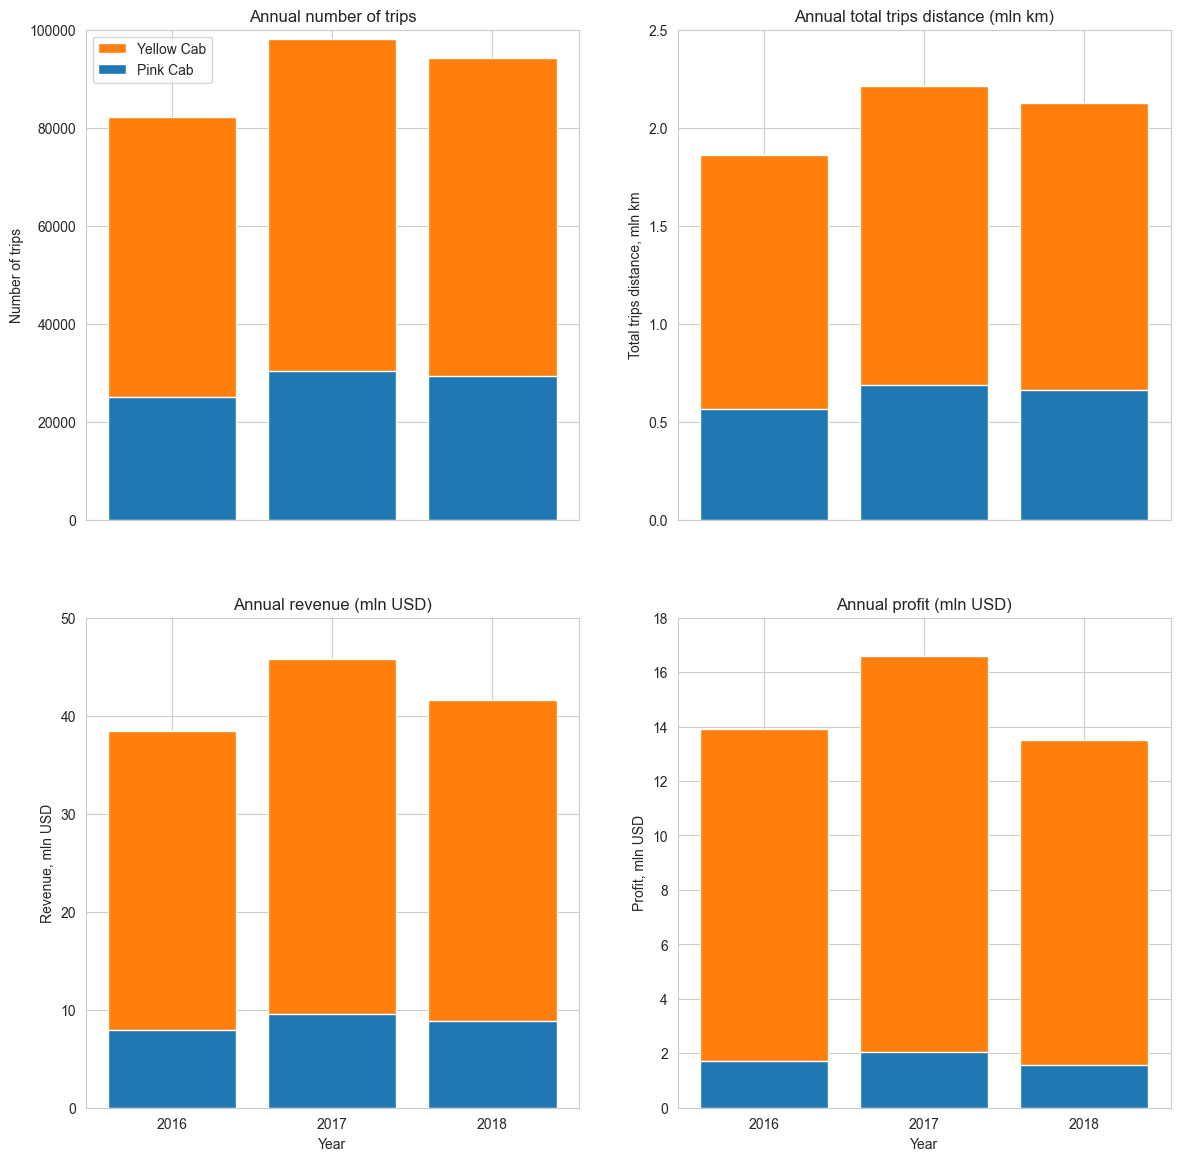

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(14, 14), sharex=True)
col_width = 0.6
# 1st subplot is about annual number of trips
for ccode, company, color_idx in zip(['y', 'p'], ['Yellow Cab', 'Pink Cab'], [y_color, p_color]): 
    axs[0, 0].bar(x=df_annual_ind.loc[(ccode)].year, height=df_annual_ind.loc[(ccode), ('transaction_id', 'count')], color=color_idx, label=company) #sns.color_palette()[color_idx]
axs[0, 0].set_title('Annual number of trips')
axs[0, 0].set_ybound(lower=0, upper=1e5)
axs[0, 0].set_ylabel('Number of trips')
axs[0, 0].legend()

# 2nd plot is about annual total km
for ccode, company, color_idx in zip(['y', 'p'], ['Yellow Cab', 'Pink Cab'], [y_color, p_color]):
    axs[0, 1].bar(x=df_annual_ind.loc[(ccode)].year, height=df_annual_ind.loc[(ccode), ('trip_distance', 'sum')], color=color_idx, label=company) #sns.color_palette()[color_idx]
axs[0, 1].set_title('Annual total trips distance (mln km)')
axs[0, 1].set_ybound(lower=0, upper=2.5e6)
axs[0, 1].set_yticklabels([0.5*i for i in range(6)])
axs[0, 1].set_ylabel('Total trips distance, mln km')

# 3rd plot is about annually amounts received
for ccode, company, color_idx in zip(['y', 'p'], ['Yellow Cab', 'Pink Cab'], [y_color, p_color]):
    axs[1, 0].bar(x=df_annual_ind.loc[(ccode)].year, height=df_annual_ind.loc[(ccode), ('amount_received', 'sum')], color=color_idx, label=company) #sns.color_palette()[color_idx]
axs[1, 0].set_title('Annual revenue (mln USD)')
axs[1, 0].set_xticks([2016, 2017, 2018])
axs[1, 0].set_ylabel('Revenue, mln USD')
axs[1, 0].set_ybound(lower=0, upper=5e7)
axs[1, 0].set_yticklabels([10*i for i in range(6)])
axs[1, 0].set_xlabel('Year')

# 4th plot is about profit received
for ccode, company, color_idx in zip(['y', 'p'], ['Yellow Cab', 'Pink Cab'], [y_color, p_color]):
    axs[1, 1].bar(x=df_annual_ind.loc[(ccode)].year, height=df_annual_ind.loc[(ccode), ('profit_per_trip', 'sum')], color=color_idx, label=company) #sns.color_palette()[color_idx]
axs[1, 1].set_title("Annual profit (mln USD)")
axs[1, 1].set_xticks([2016, 2017, 2018])
axs[1, 1].set_ylabel('Profit, mln USD')
axs[1, 1].set_ybound(lower=0, upper=18e6)
axs[1, 1].set_yticklabels([str(2*i) for i in range(11)])
axs[1, 1].set_xlabel('Year');

> Conclusions:  
(1) Both companies have similar annual dynamics patterns in number of trips, trips total distance and amount received  
(2) 'Yellow Cab' company is about 3 times bigger than 'Pink Cab' in terms of total number of trips, trips distance and revenue (amount received from known trips)  
(3) 'Yellow Cab' has total amount of profit about 7-8 times bigger than 'Pink Cab' company  
(4) Mean trip distance for both companies are near equal (22.5-22.6 km)  
(5) Mean value of the amount received per trip for 'Yellow Cab' is higher by 140-150 USD while mean cost per trip is higher only by 49-50 USD   

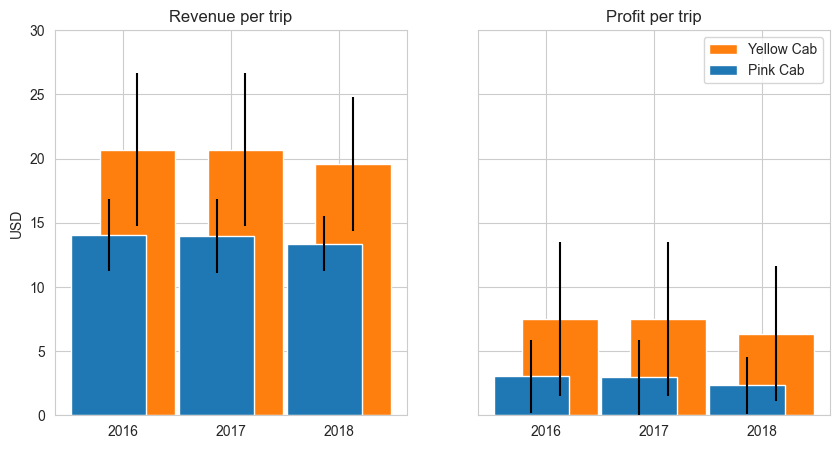

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
for ccode, company, color_idx, bar_width in zip(['y', 'p'], ['Yellow Cab', 'Pink Cab'], [y_color, p_color], [0.4, -0.4]):
    axs[0].bar(
        x=df_annual_ind.loc[(ccode)].year + bar_width/3,
        height=df_annual_ind.loc[(ccode), ('revenue_per_km', 'mean')],
        width=0.7,
        yerr=df_annual_ind.loc[(ccode), ('revenue_per_km', 'std')],
        color=color_idx, #sns.color_palette()[color_idx],
        label=company
    )
axs[0].set_title('Revenue per trip')
axs[0].set_ylabel('USD')
#axs[0].legend()

for ccode, company, color_idx, bar_width in zip(['y', 'p'], ['Yellow Cab', 'Pink Cab'], [y_color, p_color], [0.4, -0.4]):
    axs[1].bar(
        x=df_annual_ind.loc[(ccode)].year + bar_width/3,
        height=df_annual_ind.loc[(ccode), ('profit_per_km', 'mean')],
        width=0.7,
        yerr=df_annual_ind.loc[(ccode), ('profit_per_km', 'std')],
        color=color_idx, #sns.color_palette()[color_idx],
        label=company
    )
axs[1].set_title('Profit per trip')
axs[1].set_xticks([2016, 2017, 2018])
axs[1].set_ybound(lower=0, upper=30)
axs[1].legend();

Here we can see that the 'Pink Cab' has standard deviation of the profit per 1 trip near equal mean value which makes this company less attractive for investors 

To ensure our conclusions are right let's test if differences we see are statistically significant.  
As amount and cost per trip depend on trip distance we will check differences in unit indicators: revenue_per_km and cost_per_km.

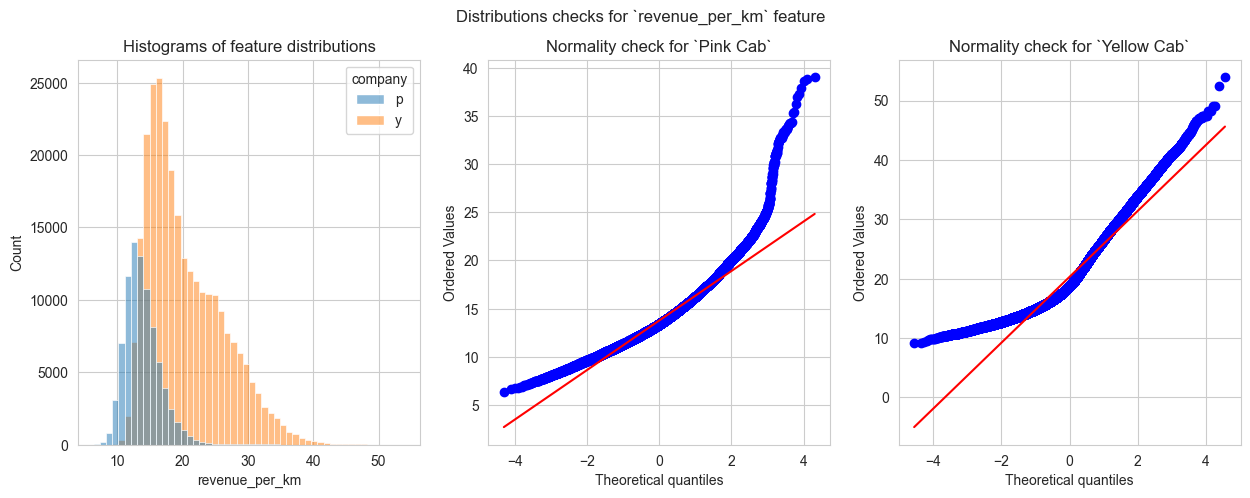

In [15]:
# For 'revenue_per_km'
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Distributions checks for `revenue_per_km` feature')
sns.histplot(data=df, x='revenue_per_km', hue='company', bins=50, ax=axs[0])
stats.probplot(df[df['company'] == 'p']['revenue_per_km'], dist="norm", plot=axs[1])
stats.probplot(df[df['company'] == 'y']['revenue_per_km'], dist="norm", plot=axs[2])
axs[0].set_title('Histograms of feature distributions')
axs[1].set_title('Normality check for `Pink Cab`')
axs[2].set_title('Normality check for `Yellow Cab`');

In [16]:
y_quantiles = []
p_quantiles = []
for i in range(101):
    y_quantiles.append(df[df['company'] == 'y']['revenue_per_km'].quantile(q=float(i)/100.0))
    p_quantiles.append(df[df['company'] == 'p']['revenue_per_km'].quantile(q=float(i)/100.0))

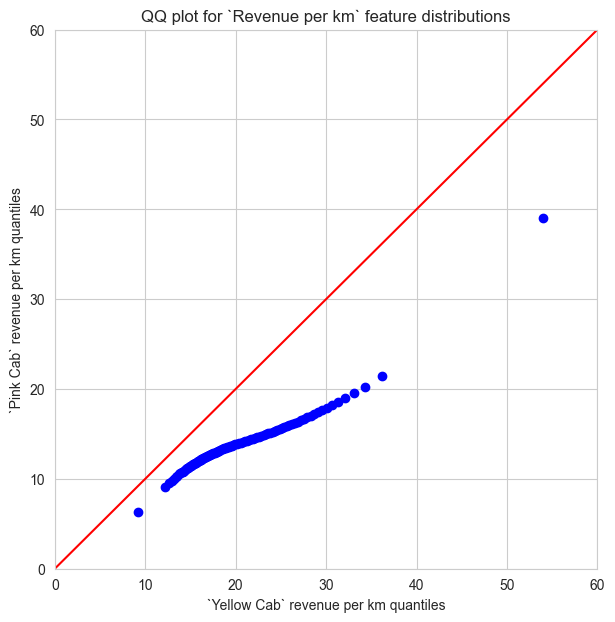

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.scatter(x=y_quantiles, y=p_quantiles, c='blue')
ax.plot([0, 60], [0, 60], c='red')
ax.set_xbound(lower=0, upper=60)
ax.set_ybound(lower=0, upper=60)
ax.set_xlabel("`Yellow Cab` revenue per km quantiles")
ax.set_ylabel("`Pink Cab` revenue per km quantiles")
ax.set_title('QQ plot for `Revenue per km` feature distributions');

The plot shows that dustributions differ from each other and both are non-normal. Therefore to determine if both companies have the same distribution's median values we should use Kruskal-Wallis test.  
$H_0$ hypothesis is that median (and therefore mean) values of revenue per trip for both companies are the same. $H_1$ (alternative) hypothesis - median values differ.

In [18]:
stats.kruskal(df[df['company'] == 'p']['revenue_per_km'], df[df['company'] == 'y']['revenue_per_km'])

KruskalResult(statistic=108321.74336195752, pvalue=0.0)

As p-value of the test is less than significance level stated (alpha = 0.05), the median values (and the mean values as well) of the 'revenue_per_km' for 'Pink Cab' and 'Yellow Cab' have statistically significant difference.  
Now let's perform the same exploration for cost_per_km feature

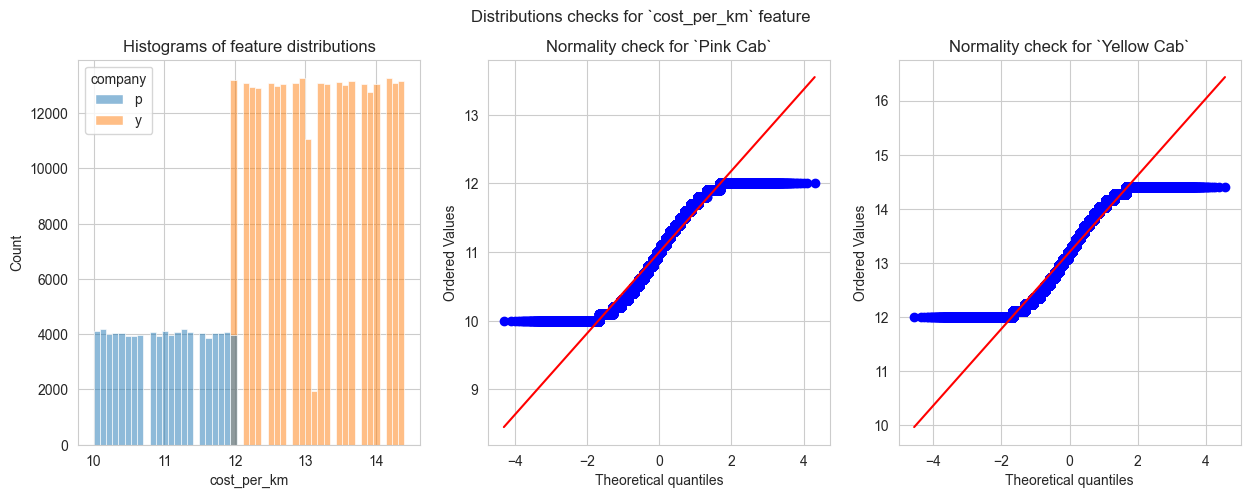

In [19]:
# For 'cost_per_km'
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Distributions checks for `cost_per_km` feature')
sns.histplot(data=df, x='cost_per_km', hue='company', bins=50, ax=axs[0])
stats.probplot(df[df['company'] == 'p']['cost_per_km'], dist="norm", plot=axs[1])
stats.probplot(df[df['company'] == 'y']['cost_per_km'], dist="norm", plot=axs[2])
axs[0].set_title('Histograms of feature distributions')
axs[1].set_title('Normality check for `Pink Cab`')
axs[2].set_title('Normality check for `Yellow Cab`');

'cost_per_km' feature demonstrates near uniform distribution which is unusual. But again to determine if the difference between mean values is statistically significant we should use Kruskal-Wallis test

In [20]:
stats.kruskal(df[df['company'] == 'p']['cost_per_km'], df[df['company'] == 'y']['cost_per_km'])

KruskalResult(statistic=193418.42726381434, pvalue=0.0)

As p-value of the test is less than significance level stated (alpha = 0.05), the median values (and the mean values as well) of the 'cost_per_km' for 'Pink Cab' and 'Yellow Cab' have statistically significant difference.

> Conclusion: Based on tests performed we can be sure that our values and conclusions about financial indicators of both companies are right.

In [21]:
for code, company in zip(['p', 'y'], ['Pink Cab', 'Yellow Cab']):
    print('='*15)
    print('Unprofitable trips of `{}`:'.format(company))
    print('-'*15)
    for year in [2016, 2017, 2018]:
        tmp = df[(df['company'] == code) & (df['trip_date'].dt.year == year)]
        trips = tmp[tmp['profit_per_trip'] < 0]['profit_per_trip'].count()
        loss = np.round(tmp[tmp['profit_per_trip'] < 0]['profit_per_trip'].sum(), 2)
        print('{}: {} ({:.2f}%) worth {} USD'.format(year, trips, trips/len(tmp)*100, loss))

Unprofitable trips of `Pink Cab`:
---------------
2016: 3241 (12.92%) worth -71200.58 USD
2017: 4362 (14.39%) worth -95193.4 USD
2018: 3526 (12.03%) worth -60278.22 USD
Unprofitable trips of `Yellow Cab`:
---------------
2016: 3886 (4.73%) worth -78037.6 USD
2017: 5095 (5.19%) worth -106178.34 USD
2018: 4709 (5.00%) worth -74882.58 USD


> Conclusion:  
(1) Both companies have unprofitable trips. Total sum of losses by years looks similar. The difference is in quantity of such trips relative to total trips quantity: 'Pink Cab' have every 7th trip unprofitable while 'Yellow Cab' only each 20th.

### 1.2. Seasoning factor

Let's explore if there is a seasonal factor in business activity of both companies. And if they differ in terms of seasonal range

In [22]:
df_for_plot = df.groupby(['company', df['trip_date'].dt.year, df['trip_date'].dt.month]).agg({'transaction_id': 'count'})
df_for_plot = df_for_plot.reset_index(2).rename(columns={'trip_date': 'month', 'transaction_id': 'trips_quantity'}).reset_index(1).rename(columns={'trip_date': 'year'})
df_for_plot.head()

,year,month,trips_quantity
company,,,
p,2016,1,927
p,2016,2,1050
p,2016,3,1231
p,2016,4,1240
p,2016,5,1567


In [23]:
# calculate additional basic statistics for years
monthly_stat = df_for_plot.reset_index().groupby(by=['company', 'year']).agg({'trips_quantity': ['min', 'max', 'mean', 'std']}).droplevel(0, axis=1)
monthly_stat['range_abs'] = monthly_stat['max'] - monthly_stat['min']
monthly_stat['range_ratio'] = monthly_stat['range_abs'] / monthly_stat['mean']
monthly_stat['coef_of_variation'] = monthly_stat['std'] / monthly_stat['mean']
monthly_stat

min    max       mean        std  range_abs  range_ratio  \
company year                                                              
p       2016   927   3521  2090.0000   944.2814       2594       1.2411   
        2017  1195   4247  2526.7500  1083.1495       3052       1.2079   
        2018  1130   3897  2442.5000   970.4411       2767       1.1329   
y       2016  3719  10827  6853.2500  2205.5315       7108       1.0372   
        2017  5358  12846  8182.4167  2423.1148       7488       0.9151   
        2018  4900  11766  7854.4167  2221.8130       6866       0.8742   

              coef_of_variation  
company year                     
p       2016             0.4518  
        2017             0.4287  
        2018             0.3973  
y       2016             0.3218  
        2017             0.2961  
        2018             0.2829

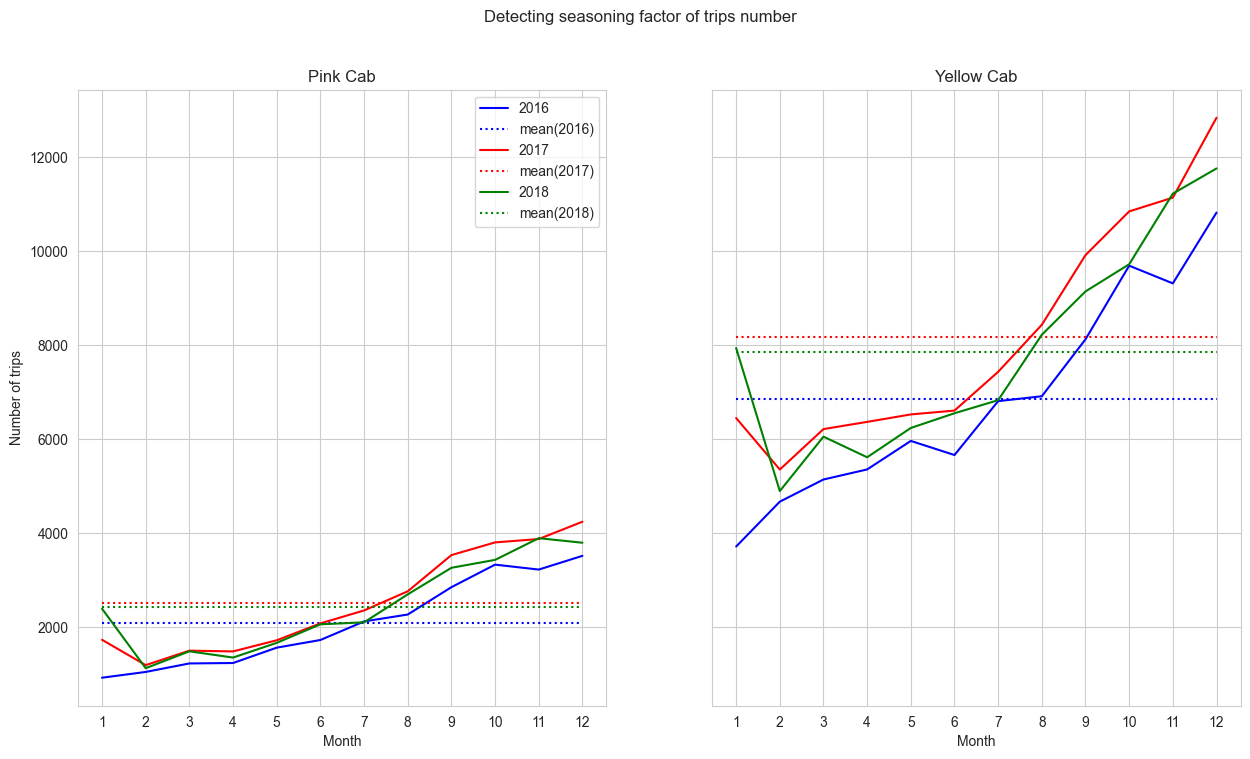

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8), sharey=True)
for year,  style in zip(df_for_plot.loc['p', 'year'].value_counts().index, ['b', 'r', 'g']):
    axs[0].plot(df_for_plot[df_for_plot['year'] == year].loc['p'].month, df_for_plot[df_for_plot['year'] == year].loc['p'].trips_quantity, '-'+style, label=str(year))
    axs[0].plot([1, 12], [monthly_stat.loc[('p', year), 'mean'], monthly_stat.loc[('p', year), 'mean']], ':'+style, label=f'mean({year})')
    axs[1].plot(df_for_plot[df_for_plot['year'] == year].loc['y'].month, df_for_plot[df_for_plot['year'] == year].loc['y'].trips_quantity, '-'+style, label=str(year))
    axs[1].plot([1, 12], [monthly_stat.loc[('y', year), 'mean'], monthly_stat.loc[('y', year), 'mean']], ':'+style, label=f'mean({year})')

fig.suptitle('Detecting seasoning factor of trips number')
axs[0].set_title('Pink Cab')
axs[0].set_xticks([x+1 for x in range(12)])
axs[1].set_title('Yellow Cab')
axs[1].set_xticks([x+1 for x in range(12)])
axs[0].set_xlabel('Month')
axs[1].set_xlabel('Month')
axs[0].set_ylabel('Number of trips')
axs[0].legend();

> Conclusions:  
(1) Both companies have similar seasoning factor in their business according to data available  
(2) 'Pink Cab' company have 1.4 times greater seasonal variability compared to 'Yellow Cab' which can be more risky

### 1.3. Customers quantity and dynamics

Comparing unique customers number for each company

In [25]:
df_customers_agg = df.groupby(by=['company', df['trip_date'].dt.year])['customer_id'].nunique().reset_index().rename(columns={'trip_date': 'year'})

Let's find out if companies' number of clients trends are different

In [26]:
# trendlines
p_trend = np.poly1d(np.polyfit(df_customers_agg[df_customers_agg['company'] == 'p']['year'], df_customers_agg[df_customers_agg['company'] == 'p']['customer_id'], 1))
y_trend = np.poly1d(np.polyfit(df_customers_agg[df_customers_agg['company'] == 'y']['year'], df_customers_agg[df_customers_agg['company'] == 'y']['customer_id'], 1))
print('Trendline of `Pink Cab` company parameters: ', p_trend)
print('Trendline of `Yellow Cab` company parameters: ', y_trend)

Trendline of `Pink Cab` company parameters:   
869.5 x - 1.736e+06
Trendline of `Yellow Cab` company parameters:   
766.5 x - 1.519e+06


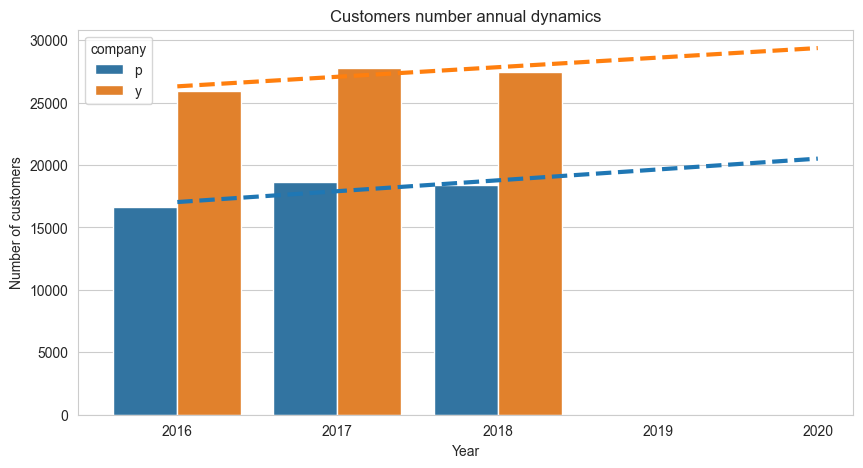

In [27]:
# Plotting customers annual dynamic
fig, ax = plt.subplots(figsize=(10, 5))
g = sns.barplot(
    data=df_customers_agg,
    x='year', y='customer_id', hue='company', hue_order=['p', 'y'], ax=ax
)
years = np.array([2016, 2017, 2018, 2019, 2020])
ax.plot([0, 1, 2, 3, 4], p_trend(years), linewidth=3, linestyle='--', label='_Pink Cab trendline') #, color=p_color
ax.plot([0, 1, 2, 3, 4], y_trend(years), color=y_color, linewidth=3, linestyle='--', label='_Yellow Cab trendline')
ax.set_title('Customers number annual dynamics')
ax.set_xlabel('Year')
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_xticklabels(years)
ax.set_ylabel('Number of customers');
#ax.legend(labels=['Pink Cab', 'Yellow Cab'])
#g._legend.set_title('new_title') # sets legend title
# replace labels
#for t, l in zip(g._legend.texts, ['Pink Cab', 'Yellow Cab']):
#    t.set_text(l)

We can see that trendlines are slightly different indeed (from the corresponding coefficients in trends equations). We can calculate the year both companies' trends will cross

In [28]:
np.round((y_trend[0] - p_trend[0])/(p_trend[1] - y_trend[1]))

2106.0

> Conclusion:  
(1) Using current trends Pink Cab's customers number will be equal to Yellow Cab's in 2100s. It's too far to take this opportunity into account when making investment decision

### 1.4. Geographical analysis

In [29]:
df_grouped = df.groupby(by=['company', 'city', df['trip_date'].dt.year])
df_grouped['customer_id'].count().rename('trips_quantity')

company  city           trip_date
p        ATLANTA GA     2016           524
                        2017           632
                        2018           606
         AUSTIN TX      2016           541
                        2017           677
                                     ...  
y        TUCSON AZ      2017           402
                        2018           396
         WASHINGTON DC  2016         12187
                        2017         14032
                        2018         13826
Name: trips_quantity, Length: 114, dtype: int64

In [30]:
df_grouped['customer_id'].nunique().rename('customers_quantity')

company  city           trip_date
p        ATLANTA GA     2016          477
                        2017          577
                        2018          545
         AUSTIN TX      2016          499
                        2017          597
                                     ... 
y        TUCSON AZ      2017          367
                        2018          372
         WASHINGTON DC  2016         2944
                        2017         2966
                        2018         2959
Name: customers_quantity, Length: 114, dtype: int64

In [31]:
df_cities_agg = df.groupby(by=['company', 'city', df['trip_date'].dt.year]).agg({
    'transaction_id': ['count'],
    'customer_id': [pd.Series.nunique],
    'trip_distance': ['sum', 'mean', 'std', 'median'],
    'amount_received': ['sum', 'mean', 'std', 'median'],
    'trip_cost': ['sum', 'mean', 'std', 'median'],
    'profit_per_trip': ['sum', 'mean', 'std', 'median'],
    'revenue_per_km': ['mean', 'std', 'median'],
    'cost_per_km': ['mean', 'std', 'median'],
    'profit_per_km': ['mean', 'std', 'median']
})
df_cities_agg

transaction_id customer_id trip_distance  \
                                         count     nunique           sum   
company city          trip_date                                            
p       ATLANTA GA    2016                 524         477      11549.06   
                      2017                 632         577      14385.94   
                      2018                 606         545      13780.17   
        AUSTIN TX     2016                 541         499      11860.49   
                      2017                 677         597      15180.70   
...                                        ...         ...           ...   
y       TUCSON AZ     2017                 402         367       8875.46   
                      2018                 396         372       8571.69   
        WASHINGTON DC 2016               12187        2944     274019.78   
                      2017               14032        2966     318945.93   
                      2018               13826        2959     313073.00   

                                                          amount_received  \
                                    mean      std  median             sum   
company city          trip_date                                             
p       ATLANTA GA    2016       22.0402  12.4077  21.890      1.6125e+05   
                      2017       22.7626  12.1103  23.100      1.9171e+05   
                      2018       22.7396  12.1778  23.780      1.7939e+05   
        AUSTIN TX     2016       21.9233  12.5847  21.420      1.7302e+05   
                      2017       22.4235  12.1945  22.600      2.2710e+05   
...                                  ...      ...     ...             ...   
y       TUCSON AZ     2017       22.0783  11.8470  22.785      1.4780e+05   
                      2018       21.6457  12.2847  20.795      1.3934e+05   
        WASHINGTON DC 2016       22.4846  12.2048  22.200      4.5932e+06   
                      2017       22.7299  12.2987  22.610      5.5856e+06   
                      2018       22.6438  12.2974  22.455      5.0804e+06   

                                                              ...  \
                                     mean       std   median  ...   
company city          trip_date                               ...   
p       ATLANTA GA    2016       307.7377  183.6907  299.080  ...   
                      2017       303.3446  174.0745  287.800  ...   
                      2018       296.0189  164.7442  301.980  ...   
        AUSTIN TX     2016       319.8083  195.0458  302.850  ...   
                      2017       335.4547  197.5490  324.470  ...   
...                                   ...       ...      ...  ...   
y       TUCSON AZ     2017       367.6623  221.0700  351.895  ...   
                      2018       351.8562  212.0921  320.410  ...   
        WASHINGTON DC 2016       376.8912  216.3284  365.120  ...   
                      2017       398.0629  228.9150  388.000  ...   
                      2018       367.4530  205.5783  359.655  ...   

                                profit_per_trip revenue_per_km          \
                                         median           mean     std   
company city          trip_date                                          
p       ATLANTA GA    2016              47.9350        14.0198  2.6733   
                      2017              39.0325        13.3141  2.3049   
                      2018              31.0940        12.9908  1.7753   
        AUSTIN TX     2016              55.3000        14.6313  2.9441   
                      2017              63.5020        14.9788  2.8798   
...                                         ...            ...     ...   
y       TUCSON AZ     2017              48.7176        16.6680  3.6356   
                      2018              42.9474        16.1071  2.5665   
        WASHINGTON DC 2016              55.7500        16.7579  2.7829   
                      2017       

In [32]:
columns = ['_'.join(x) for x in df_cities_agg.columns]
df_cities_agg = df_cities_agg.droplevel(0, axis=1)
df_cities_agg.columns = columns
df_cities_agg = df_cities_agg.rename(columns={'transaction_id_count': 'trips_quantity', 'customer_id_nunique': 'customers_quantity'}).rename_axis(index={'trip_date': 'year'})
df_cities_agg = df_cities_agg.reset_index().merge(right=pd.read_csv('datasets/processed/cities.csv', index_col=0), how='left', on='city').set_index(keys=['company', 'year'])#, 'city', ])
df_cities_agg['market_share'] = df_cities_agg['customers_quantity'] / df_cities_agg['num_users'] * 100
df_cities_agg

city  trips_quantity  customers_quantity  \
company year                                                      
p       2016     ATLANTA GA             524                 477   
        2017     ATLANTA GA             632                 577   
        2018     ATLANTA GA             606                 545   
        2016      AUSTIN TX             541                 499   
        2017      AUSTIN TX             677                 597   
...                     ...             ...                 ...   
y       2017      TUCSON AZ             402                 367   
        2018      TUCSON AZ             396                 372   
        2016  WASHINGTON DC           12187                2944   
        2017  WASHINGTON DC           14032                2966   
        2018  WASHINGTON DC           13826                2959   

              trip_distance_sum  trip_distance_mean  trip_distance_std  \
company year                                                             
p       2016           11549.06             22.0402            12.4077   
        2017           14385.94             22.7626            12.1103   
        2018           13780.17             22.7396            12.1778   
        2016           11860.49             21.9233            12.5847   
        2017           15180.70             22.4235            12.1945   
...                         ...                 ...                ...   
y       2017            8875.46             22.0783            11.8470   
        2018            8571.69             21.6457            12.2847   
        2016          274019.78             22.4846            12.2048   
        2017          318945.93             22.7299            12.2987   
        2018          313073.00             22.6438            12.2974   

              trip_distance_median  amount_received_sum  amount_received_mean  \
company year                                                                    
p       2016                21.890           1.6125e+05              307.7377   
        2017                23.100           1.9171e+05              303.3446   
        2018                23.780           1.7939e+05              296.0189   
        2016                21.420           1.7302e+05              319.8083   
        2017                22.600           2.2710e+05              335.4547   
...                            ...                  ...                   ...   
y       2017                22.785           1.4780e+05              367.6623   
        2018                20.795           1.3934e+05              351.8562   
        2016                22.200           4.5932e+06              376.8912   
        2017                22.610           5.5856e+06              398.0629   
        2018                22.455           5.0804e+06              367.4530   

              amount_received_std  ...  revenue_per_km_median  \
company year                       ...                          
p       2016             183.6907  ...                13.9266   
        2017             174.0745  ...                13.2807   
        2018             164.7442  ...                12.6962   
        2016             195.0458  ...                14.2713   
        2017             197.5490  ...                14.8355   
...                           ...  ...                    ...   
y       2017             221.0700  ...                16.1996   
        2018             212.0921  ...                15.5626   
        2016             216.3284  ...                16.3221   
        2017             228.9150  ...                17.2229   
        2018             205.5783  ...                16.0083   

              cost_per_km_mean  cost_per_km_std  cost_per_km_median  \
company year                                                          
p       2016           10.9594           0.5929                11.0   
        2017           10.9517           0.5874                10.9   
    

In [33]:
# x = sorted(list({x[1] for x in df_cities_agg.index.to_list()})) # get cities w/o duplicates when cities included to index at level 1
x_cities = sorted(df_cities_agg['city'].unique())

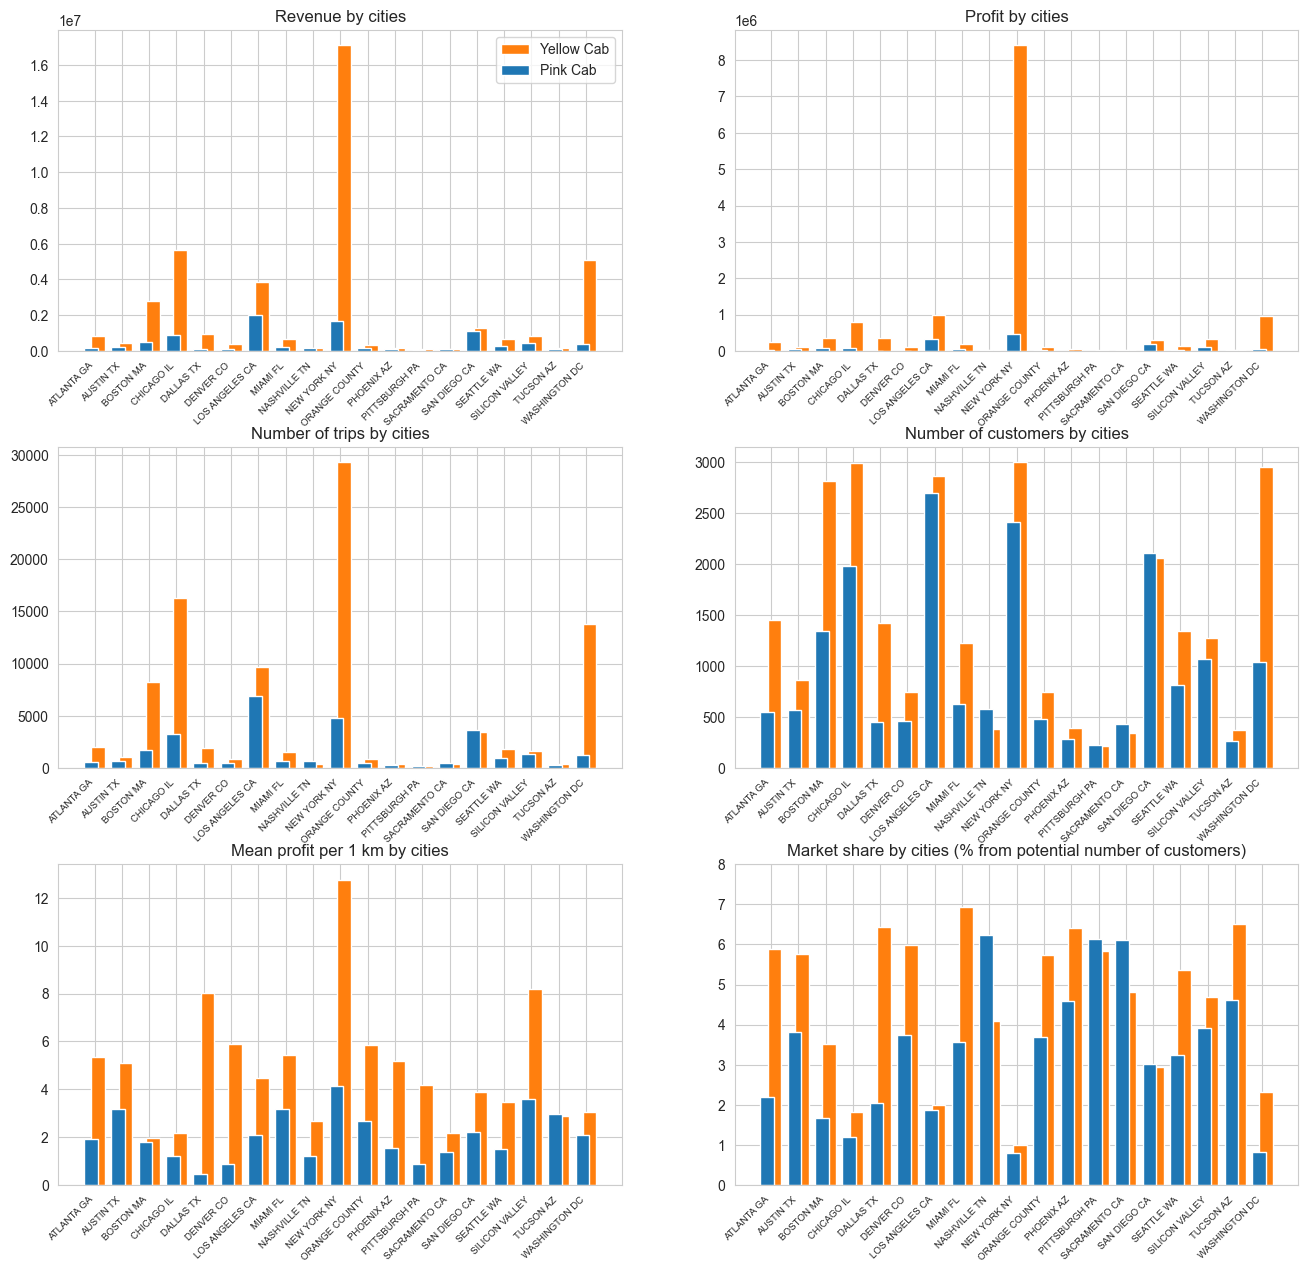

In [34]:
bar_width = 0.4
"""
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)
"""
fig, axs = plt.subplots(3, 2, figsize=(16, 15))  #sharex=True
fig.subplots_adjust(hspace=0.3)

# plot for total revenue by cities in 2018
indicator = 'amount_received_sum'
axs[0, 0].bar(x=[i+bar_width/3 for i in range(len(x_cities))], height=df_cities_agg.loc[('y', 2018)].sort_values(by=['city'])[indicator], width=0.5, color=sns.color_palette()[1], label='Yellow Cab')
axs[0, 0].bar(x=[i-bar_width/3 for i in range(len(x_cities))], height=df_cities_agg.loc[('p', 2018)].sort_values(by=['city'])[indicator], width=0.5, color=sns.color_palette()[0], label='Pink Cab')
axs[0, 0].set_xticks([i for i in range(len(x_cities))])
axs[0, 0].set_xticklabels(x_cities, rotation = 45, fontsize=7, horizontalalignment='right'); # instead of 'horizontalalignment' one can use 'ha'
axs[0, 0].legend()
axs[0, 0].set_title('Revenue by cities');
#axs.set_yscale('log');

# plot for profit by cities in 2018
indicator = 'profit_per_trip_sum'
axs[0, 1].bar(x=[i+bar_width/3 for i in range(len(x_cities))], height=df_cities_agg.loc[('y', 2018)].sort_values(by=['city'])[indicator], width=0.5, color=sns.color_palette()[1], label='Yellow Cab')
axs[0, 1].bar(x=[i-bar_width/3 for i in range(len(x_cities))], height=df_cities_agg.loc[('p', 2018)].sort_values(by=['city'])[indicator], width=0.5, color=sns.color_palette()[0], label='Pink Cab')
axs[0, 1].set_xticks([i for i in range(len(x_cities))])
axs[0, 1].set_xticklabels(x_cities, rotation = 45, fontsize=7, ha='right')
axs[0, 1].set_title('Profit by cities');
#axs.set_yscale('log');

# plot for number of trips by cities in 2018
indicator = 'trips_quantity'
axs[1, 0].bar(x=[i+bar_width/3 for i in range(len(x_cities))], height=df_cities_agg.loc[('y', 2018)].sort_values(by=['city'])[indicator], width=0.5, color=sns.color_palette()[1], label='Yellow Cab')
axs[1, 0].bar(x=[i-bar_width/3 for i in range(len(x_cities))], height=df_cities_agg.loc[('p', 2018)].sort_values(by=['city'])[indicator], width=0.5, color=sns.color_palette()[0], label='Pink Cab')
axs[1, 0].set_xticks([i for i in range(len(x_cities))])
axs[1, 0].set_xticklabels(x_cities, rotation = 45, fontsize=7, ha='right')
axs[1, 0].set_title('Number of trips by cities');

# plot for number of customers by cities in 2018
indicator = 'customers_quantity'
axs[1, 1].bar(x=[i+bar_width/3 for i in range(len(x_cities))], height=df_cities_agg.loc[('y', 2018)].sort_values(by=['city'])[indicator], width=0.5, color=sns.color_palette()[1], label='Yellow Cab')
axs[1, 1].bar(x=[i-bar_width/3 for i in range(len(x_cities))], height=df_cities_agg.loc[('p', 2018)].sort_values(by=['city'])[indicator], width=0.5, color=sns.color_palette()[0], label='Pink Cab')
axs[1, 1].set_xticks([i for i in range(len(x_cities))])
axs[1, 1].set_xticklabels(x_cities, rotation = 45, fontsize=7, ha='right')
axs[1, 1].set_title('Number of customers by cities');

# plot for 1 km profitability by cities in 2018
indicator = 'profit_per_km_mean'
axs[2, 0].bar(x=[i+bar_width/3 for i in range(len(x_cities))], height=df_cities_agg.loc[('y', 2018)].sort_values(by=['city'])[indicator], width=0.5, color=sns.color_palette()[1], label='Yellow Cab')
axs[2, 0].bar(x=[i-bar_width/3 for i in range(len(x_cities))], height=df_cities_agg.loc[('p', 2018)].sort_values(by=['city'])[indicator], width=0.5, color=sns.color_palette()[0], label='Pink Cab')
axs[2, 0].set_xticks([i for i in range(len(x_cities))])
axs[2, 0].set_xticklabels(x_cities, rotation = 45, fontsize=7, ha='right')
axs[2, 0].set_title('Mean profit per 1 km by cities');

# plot for market share by cities in 2018
indicator = 'market_share'
axs[2, 1].bar(x=[i+bar_width/3 for i in range(len(x_cities))], height=df_cities_agg.loc[('y', 2018)].sort_values(by=['city'])[indicator], width=0.5, color=sns.color_palette()[1], label='Yellow Cab')
axs[2, 1].bar(x=[i-bar_width/3 for i in range(len(x_cities))], height=df_cities_agg.loc[('p', 2018)].sort_values(by=['city'])[indicator], width=0.5, color=sns.color_palette()[0], label='Pink Cab')
axs[2, 1].set_xticks([i for i in range(len(x_cities))])
axs[2, 1].set_xticklabels(x_cities, rotation = 45, fontsize=7, ha='right')
axs[2, 1].set_ybound(upper=8)
axs[2, 1].set_title('Market share by cities (% from potential number of customers)'); 

Something is clearly wrong here. There are 4 cities where 'Yellow Cab' significantly outperforms 'Pink Cab' in terms of revenue and number of trips while the difference in number of customers is not so big. These are Boston, Chicago, New York and Washington.  
And New York is definitely an outlier: it has too high revenue, profit and number of trips compared to number of customers.  
Let's explore if such a situation had place in previous years.  

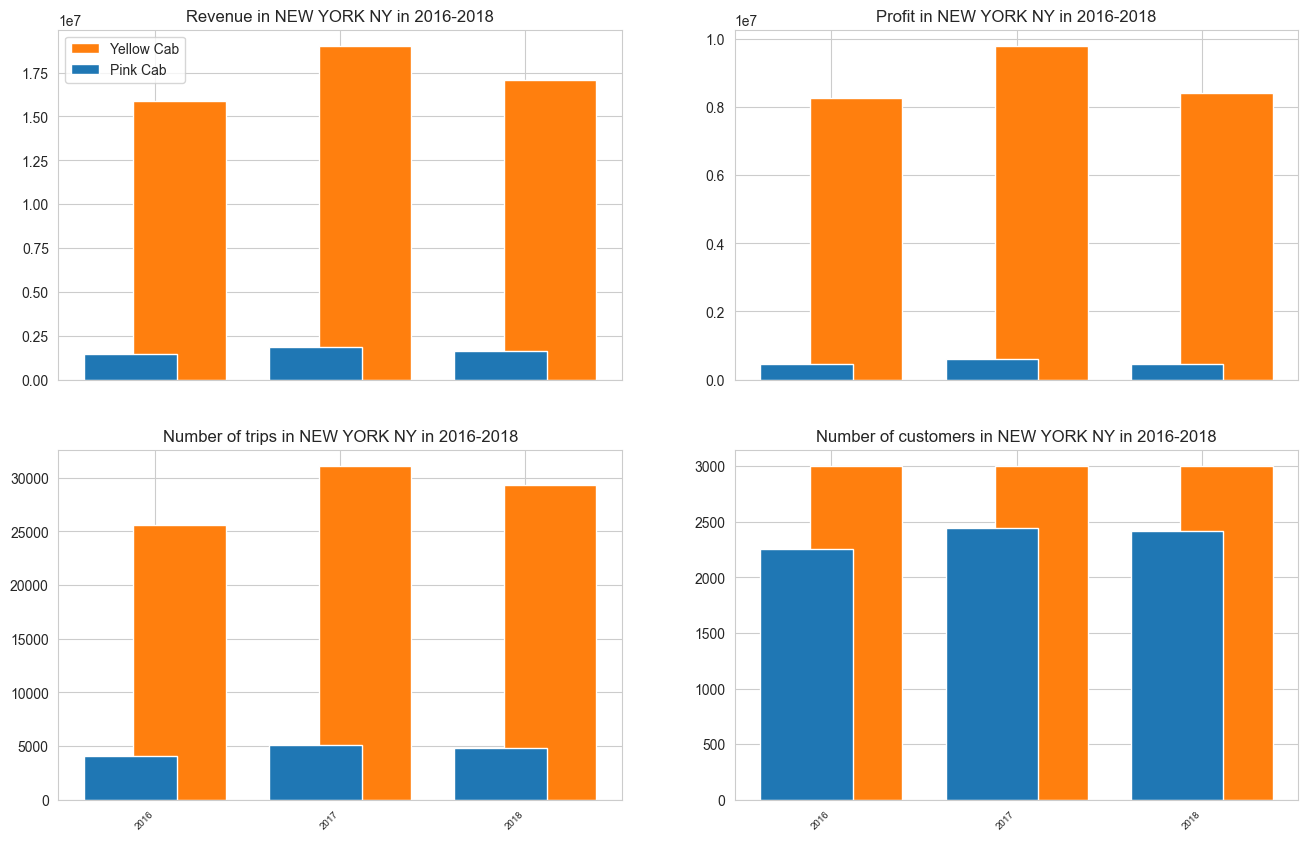

In [35]:
df_cities_agg = df_cities_agg.reset_index().set_index(keys=['company', 'city'])
target_city = 'NEW YORK NY'
x_labels = [2016, 2017, 2018]
bar_width = 0.4

fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharex=True)

# plot for annual revenue in New York in 2016-2018
indicator = 'amount_received_sum'
axs[0, 0].bar(x=[i+bar_width/3 for i in range(len(x_labels))], height=df_cities_agg.loc[('y', target_city)].sort_values(by=['year'])[indicator], width=0.5, color=sns.color_palette()[1], label='Yellow Cab')
axs[0, 0].bar(x=[i-bar_width/3 for i in range(len(x_labels))], height=df_cities_agg.loc[('p', target_city)].sort_values(by=['year'])[indicator], width=0.5, color=sns.color_palette()[0], label='Pink Cab')
axs[0, 0].set_xticks([i for i in range(len(x_labels))])
axs[0, 0].set_xticklabels(x_labels, rotation = 45, fontsize=7, horizontalalignment='right'); # instead of 'horizontalalignment' one can use 'ha'
axs[0, 0].legend()
axs[0, 0].set_title(f'Revenue in {target_city} in 2016-2018');
#axs.set_yscale('log');

# plot for annual profit in New York in 2016-2018
indicator = 'profit_per_trip_sum'
axs[0, 1].bar(x=[i+bar_width/3 for i in range(len(x_labels))], height=df_cities_agg.loc[('y', target_city)].sort_values(by=['year'])[indicator], width=0.5, color=sns.color_palette()[1], label='Yellow Cab')
axs[0, 1].bar(x=[i-bar_width/3 for i in range(len(x_labels))], height=df_cities_agg.loc[('p', target_city)].sort_values(by=['year'])[indicator], width=0.5, color=sns.color_palette()[0], label='Pink Cab')
axs[0, 1].set_xticks([i for i in range(len(x_labels))])
axs[0, 1].set_xticklabels(x_labels, rotation = 45, fontsize=7, ha='right')
axs[0, 1].set_title(f'Profit in {target_city} in 2016-2018');
#axs.set_yscale('log');

# plot for annual number of trips in 2016-2018
axs[1, 0].bar(x=[i+bar_width/3 for i in range(len(x_labels))], height=df_cities_agg.loc[('y', target_city)].sort_values(by=['year'])['trips_quantity'], width=0.5, color=sns.color_palette()[1], label='Yellow Cab')
axs[1, 0].bar(x=[i-bar_width/3 for i in range(len(x_labels))], height=df_cities_agg.loc[('p', target_city)].sort_values(by=['year'])['trips_quantity'], width=0.5, color=sns.color_palette()[0], label='Pink Cab')
axs[1, 0].set_xticks([i for i in range(len(x_labels))])
axs[1, 0].set_xticklabels(x_labels, rotation = 45, fontsize=7, ha='right')
axs[1, 0].set_title(f'Number of trips in {target_city} in 2016-2018');

# plot for annual number of customers in 2016-2018
axs[1, 1].bar(x=[i+bar_width/3 for i in range(len(x_labels))], height=df_cities_agg.loc[('y', target_city)].sort_values(by=['year'])['customers_quantity'], width=0.5, color=sns.color_palette()[1], label='Yellow Cab')
axs[1, 1].bar(x=[i-bar_width/3 for i in range(len(x_labels))], height=df_cities_agg.loc[('p', target_city)].sort_values(by=['year'])['customers_quantity'], width=0.5, color=sns.color_palette()[0], label='Pink Cab')
axs[1, 1].set_xticks([i for i in range(len(x_labels))])
axs[1, 1].set_xticklabels(x_labels, rotation = 45, fontsize=7, ha='right')
axs[1, 1].set_title(f'Number of customers in {target_city} in 2016-2018');

So this situation lasts for 3 years and can be normal. Let's see if it's one or several customers that make such an outstandig financial result for 'Yellow Cab' or if it's because of mean revenue value

In [36]:
df_cities_agg = df.groupby(by=['company', 'city', df['trip_date'].dt.year]).agg({ #, 'customer_id'
    'transaction_id': ['count'],
    #'customer_id': [pd.Series.nunique],
    'trip_distance': ['sum', 'mean', 'std'],
    'amount_received': ['sum', 'mean', 'std'],
    'trip_cost': ['sum', 'mean', 'std'],
    'profit_per_trip': ['sum', 'mean'],
    'revenue_per_km': ['mean', 'std', 'min', 'max'],
    'cost_per_km': ['mean', 'std', 'min', 'max'],
    'profit_per_km': ['mean', 'std']
})#.reset_index(level=2).rename(columns={'transaction_id': 'trips', 'trip_date': 'year'})
df_cities_agg.sort_values(by=[('transaction_id', 'count')], ascending=False)

transaction_id trip_distance           \
                                         count           sum     mean   
company city          trip_date                                         
y       NEW YORK NY   2017               31061     697707.90  22.4625   
                      2018               29275     658570.06  22.4960   
                      2016               25582     576564.51  22.5379   
        CHICAGO IL    2017               16954     384572.02  22.6833   
                      2018               16312     367953.71  22.5572   
...                                        ...           ...      ...   
p       PITTSBURGH PA 2018                 234       5247.88  22.4268   
y       PITTSBURGH PA 2018                 220       5062.96  23.0135   
                      2017                 218       4704.53  21.5804   
p       PITTSBURGH PA 2016                 209       4649.28  22.2454   
y       PITTSBURGH PA 2016                 193       4537.61  23.5109   

                                         amount_received                      \
                                     std             sum      mean       std   
company city          trip_date                                                
y       NEW YORK NY   2017       12.2107      1.8998e+07  611.6368  354.3066   
                      2018       12.1732      1.7098e+07  584.0588  327.4843   
                      2016       12.2048      1.5870e+07  620.3751  355.3956   
        CHICAGO IL    2017       12.2867      6.2505e+06  368.6739  213.5779   
                      2018       12.2401      5.6553e+06  346.6961  194.0146   
...                                  ...             ...       ...       ...   
p       PITTSBURGH PA 2018       12.3090      6.2403e+04  266.6814  161.2696   
y       PITTSBURGH PA 2018       12.2077      8.8950e+04  404.3197  268.8589   
                      2017       12.7093      8.9331e+04  409.7745  295.7897   
p       PITTSBURGH PA 2016       12.6892      5.6840e+04  271.9594  169.3407   
y       PITTSBURGH PA 2016       12.4803      7.7472e+04  401.4080  231.8005   

                                  trip_cost                      ...  \
                                        sum      mean       std  ...   
company city          trip_date                                  ...   
y       NEW YORK NY   2017       9.2122e+06  296.5852  162.3585  ...   
                      2018       8.6936e+06  296.9625  161.8194  ...   
                      2016       7.6099e+06  297.4715  162.0849  ...   
        CHICAGO IL    2017       5.0775e+06  299.4884  163.2403  ...   
                      2018       4.8544e+06  297.5999  162.5997  ...   
...                                     ...       ...       ...  ...   
p       PITTSBURGH PA 2018       5.7796e+04  246.9932  137.8013  ...   
y       PITTSBURGH PA 2018       6.5890e+04  299.5007  158.2689  ...   
                      2017       6.1898e+04  283.9347  167.0494  ...   
p       PITTSBURGH PA 2016       5.1296e+04  245.4368  141.2205  ...   
y       PITTSBURGH PA 2016       5.9907e+04  310.3978  166.0573  ...   

                                revenue_per_km                            \
                                          mean     std      min      max   
company city          trip_date                                            
y       NEW YORK NY   2017             27.2192  4.7929  17.6036  49.1199   
                      2018             25.9669  3.3979  18.4594  40.8980   
                      2016             27.5159  4.5361  17.7626  44.9105   
        CHICAGO IL    2017             16.2545  2.8915  10.6324  31.9703   
                      2018             15.3683  1.8737  11.6410  26.4289   
...                                        ...     ...      ...      ...   
p       PITTSBURGH PA 2018             11.8573  2.5611   7.5000  22.5885   
y       PITTSBURGH PA 2018             17.2281  4.4007  11.1676  45.6191   
                      2017             18.6

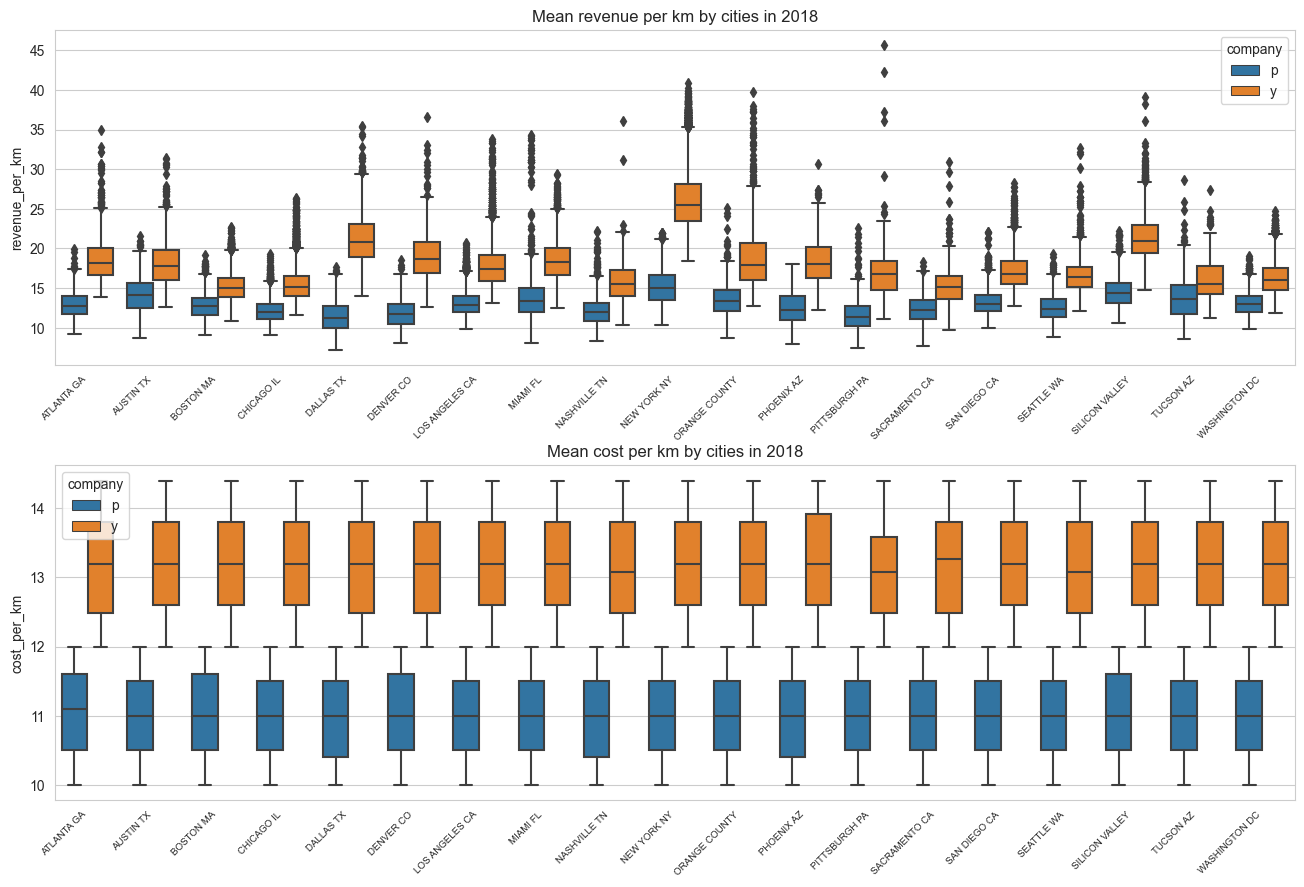

In [37]:
#df_for_plot = df_cities_agg.reset_index(level=[0,1,3]).loc[2018]
fig, axs = plt.subplots(2, 1, figsize=(16, 10))
fig.subplots_adjust(hspace=0.3)
#fig.tight_layout()
"""
subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
The parameter meanings (and suggested defaults) are:

left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.2   # the amount of height reserved for white space between subplots
"""
sns.boxplot(data=df[df['trip_date'].dt.year == 2018].sort_values(by='city'), x='city', y='revenue_per_km', hue='company', hue_order=['p','y'], ax=axs[0])
#axs[0].set_xticklabels(labels=x_cities, rotation = 45, fontsize=7, ha='right')
for label in axs[0].get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)
    label.set_fontsize(7)
axs[0].set_title('Mean revenue per km by cities in 2018')
axs[0].set_xlabel(None);

sns.boxplot(data=df[df['trip_date'].dt.year == 2018].sort_values(by='city'), x='city', y='cost_per_km', hue='company', hue_order=['p','y'], ax=axs[1])
#axs[1].set_xticklabels(labels=x_cities, rotation = 45, fontsize=7, ha='right')
for label in axs[1].get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)
    label.set_fontsize(7)
axs[1].set_title(f'Mean cost per km by cities in 2018')
axs[1].set_xlabel(None);

Here we see that mean cost per km differs for both companies, but stays at the same level in different cities. And mean revenue per km is floating. Let's test if differences between mean revenue_per_km values for cities are statistically significant.  
First we have to check the normality of value distributions in each city and across them

<AxesSubplot: xlabel="('revenue_per_km', 'mean')", ylabel='Count'>

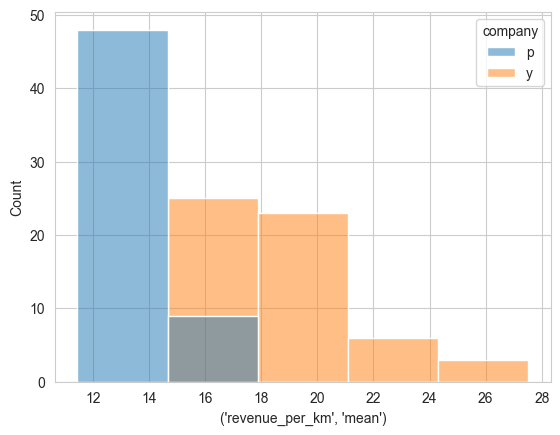

In [38]:
# between cities' mean values
sns.histplot(data=df_cities_agg.reset_index(), x=('revenue_per_km', 'mean'), bins=5, hue='company')

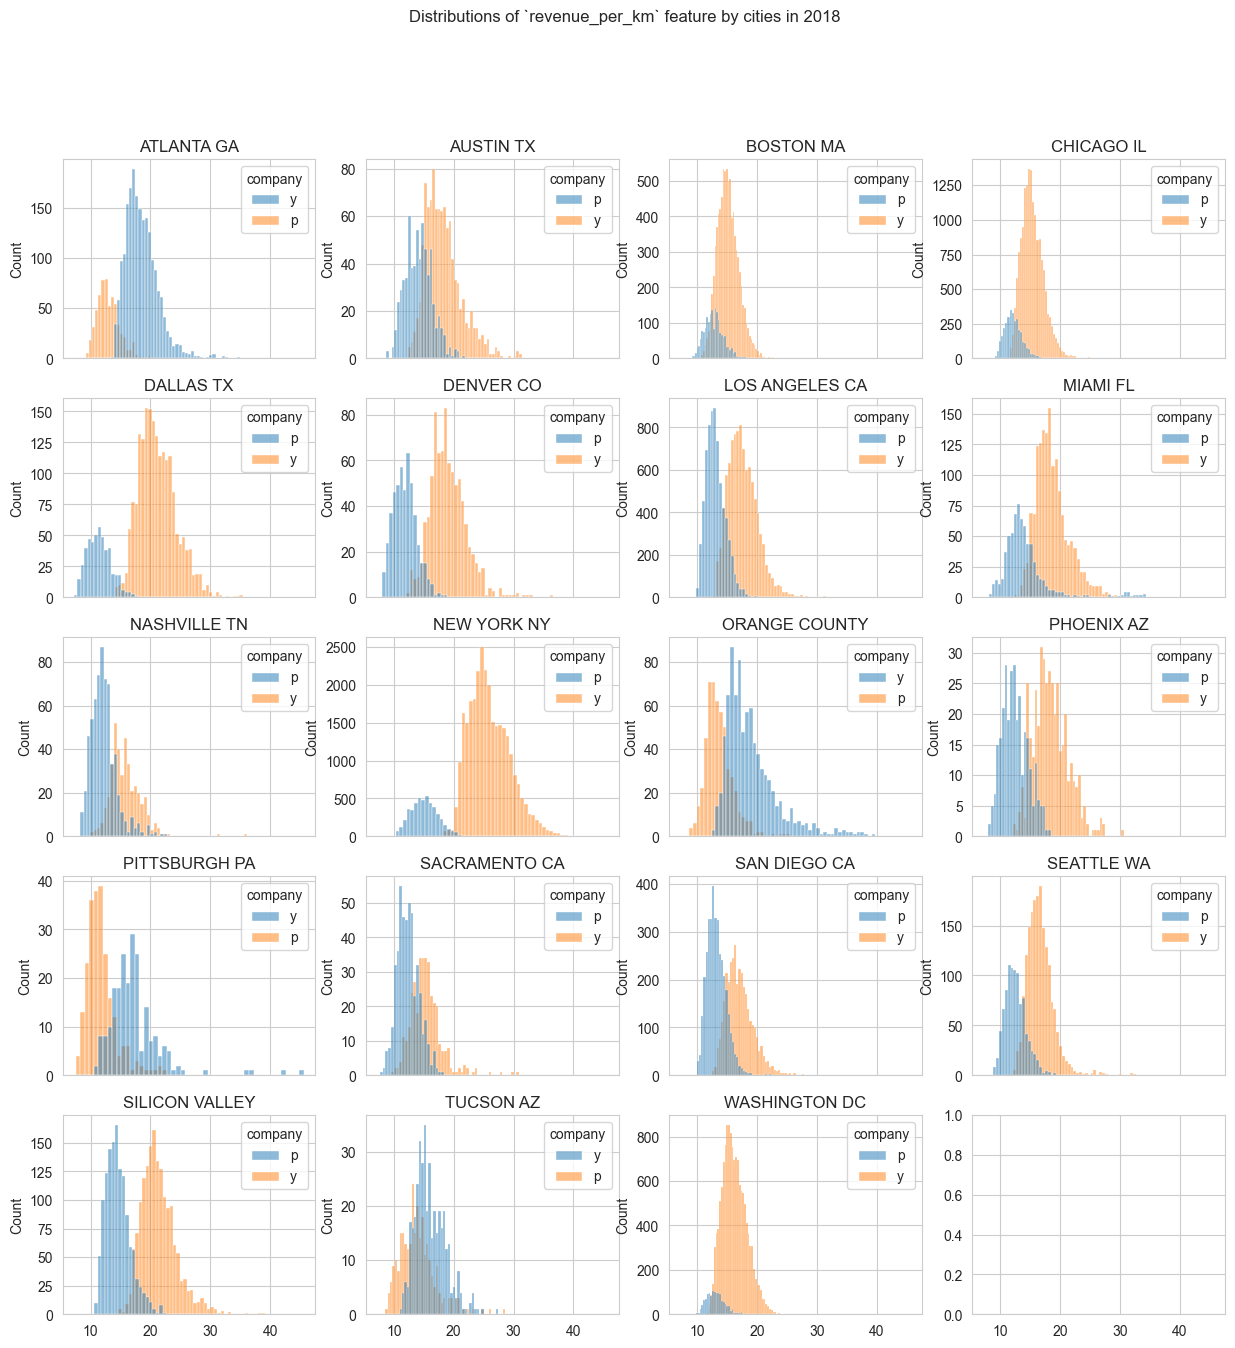

In [39]:
# inside cities' groups
cols = 4

fig, axs = plt.subplots(nrows=(len(x_cities) // cols)+1, ncols=cols, figsize=(15, 15), sharex=True)
fig.suptitle('Distributions of `revenue_per_km` feature by cities in 2018')
fig.subplots_adjust(hspace=0.2)
for city, ax in zip(x_cities, axs.flat):
    sns.histplot(data=df[(df['trip_date'].dt.year == 2018) & (df['city'] == city)], x='revenue_per_km', hue='company', bins=50, ax=ax)
    #ax.hist(x=df[(df['trip_date'].dt.year == 2018) & (df['city'] == city)]['revenue_per_km'], bins=20)
    ax.set_title(city)
    ax.set_xlabel(None)

In [40]:
kruskal_results = {}
for city in x_cities:
    kruskal_results[city] = stats.kruskal(df[(df['trip_date'].dt.year == 2018) & (df['city'] == city) & (df['company'] == 'p')]['revenue_per_km'], df[(df['trip_date'].dt.year == 2018) & (df['city'] == city) & (df['company'] == 'y')]['revenue_per_km'])
cnt = 0
for city, stat in kruskal_results.items():
    if stat[1] >= alpha_level:
        cnt += 1
        print('City: {}, test not passed +> median (mean) values are the same (p = {:.4.f})'.format(city, stat[1]))

if cnt == 0:
    print('In all cities mean revenue per km values differences are statistically signifiacnt')

In all cities mean revenue per km values differences are statistically signifiacnt


Let's investigate what customers made such a situation possible

In [41]:
grouper = df[df['trip_date'].dt.year == 2018].groupby(by=['company', 'city', 'customer_id']).agg({
    'transaction_id': ['count'],
    'amount_received': ['sum', 'mean'],
    'revenue_per_km': ['mean', 'std', 'min', 'max']
})[('transaction_id', 'count')].groupby(['company', 'city'], group_keys=False)
#df_agg['count'].groupby('job', group_keys=False).nlargest(3)

In [42]:
outliers_cities = ['BOSTON MA', 'CHICAGO IL', 'NEW YORK NY', 'WASHINGTON DC']
df_outliers = df[(df['trip_date'].dt.year == 2018) & df['city'].isin(outliers_cities)].groupby(by=['company', 'city', 'customer_id']).agg({
    'transaction_id': ['count'],
    'amount_received': ['sum', 'mean', 'std'],
    'trip_cost': ['sum', 'mean', 'std'],
    'profit_per_trip': ['sum'],
    'revenue_per_km': ['mean', 'std', 'min', 'max'],
    'cost_per_km': ['mean', 'std', 'min', 'max']
})


In [43]:
mean_trip_per_customer_by_cities = df_outliers.reset_index().groupby(by=['company', 'city']).agg({('transaction_id', 'count'): ['mean']}).droplevel(level=[0,1], axis=1).rename(columns={'mean': 'mean_trip_per_customer'}).reset_index()
mean_trip_per_customer_by_cities['ind'] = mean_trip_per_customer_by_cities.apply(lambda x: x['company']+':'+x['city'], axis=1)
mean_trip_per_customer_by_cities

,company,city,mean_trip_per_customer,ind
0,p,BOSTON MA,1.3199,p:BOSTON MA
1,p,CHICAGO IL,1.6436,p:CHICAGO IL
2,p,NEW YORK NY,1.9988,p:NEW YORK NY
3,p,WASHINGTON DC,1.2299,p:WASHINGTON DC
4,y,BOSTON MA,2.9266,y:BOSTON MA
5,y,CHICAGO IL,5.4537,y:CHICAGO IL
6,y,NEW YORK NY,9.7616,y:NEW YORK NY
7,y,WASHINGTON DC,4.6725,y:WASHINGTON DC


> Conclusion:  
(1) There are 4 cities where 'Yellow Cab' significantly outperforms 'Pink Cab' in terms of revenue and number of trips while the difference in number of customers is not so big. These are Boston, Chicago, New York and Washington.  
(2) At least half of the differences between revenues and profits of the companies are explained by outstanding operational results of 'Yellow Cab' in New York. These results are stable in time (observed over 3 consecutive years).  
(3) Results of 'Yellow Cab' in New York are based on enormous trips quantity comparing with 'Pink Cab' ones. It demands further investigation (compare results of both companies excluding New York, analyze situations in other 3 cities mentioned in (1)).  
(4) Differences between companies' mean values of the revenue per 1 km are statistically significant and they influence on financial results.

## 2. Analysis of differences in customer groups and their dynamics (to perform segmentation)

### 2.1. Differences in geographical position

Will be analyzed later

### 2.2. Differences in gender in terms of revenue

Preparing customers aggregated dataset: grouping info by company, customer_id and year and then merging aggregated data with Customer_ID table info

In [44]:
# grouping dataset to analyze customer segments
df_customers_agg = df.groupby(by=['company', 'customer_id', df['trip_date'].dt.year]).agg({
    'transaction_id': ['count'],
    'trip_distance': ['sum', 'mean'],
    'amount_received': ['sum', 'mean'],
    'trip_cost': ['sum', 'mean']
})
df_customers_agg

transaction_id trip_distance           \
                                       count           sum     mean   
company customer_id trip_date                                         
p       1           2016                   1         42.40  42.4000   
                    2017                   3         83.12  27.7067   
        2           2016                   2         55.87  27.9350   
                    2017                   1         10.71  10.7100   
                    2018                   1         29.70  29.7000   
...                                      ...           ...      ...   
y       59999       2016                   2         46.45  23.2250   
                    2018                   4         66.70  16.6750   
        60000       2016                   3         35.38  11.7933   
                    2017                   4         72.95  18.2375   
                    2018                   7        170.76  24.3943   

                              amount_received            trip_cost            
                                          sum      mean        sum      mean  
company customer_id trip_date                                                 
p       1           2016               703.09  703.0900   457.9200  457.9200  
                    2017              1583.39  527.7967   955.3960  318.4653  
        2           2016              1043.82  521.9100   576.5200  288.2600  
                    2017               186.88  186.8800   117.8100  117.8100  
                    2018               364.01  364.0100   299.9700  299.9700  
...                                       ...       ...        ...       ...  
y       59999       2016               772.61  386.3050   592.1928  296.0964  
                    2018               978.58  244.6450   875.5740  218.8935  
        60000       2016               572.25  190.7500   465.6360  155.2120  
                    2017              1362.21  340.5525   930.3084  232.5771  
                    2018              2794.48  399.2114  2263.8168  323.4024  

[134900 rows x 7 columns]

In [45]:
# Part 1 - aggregating
df_tmp = df_customers_agg.copy()
df_tmp.columns = df_tmp.columns.droplevel(0)
df_tmp.columns = ['_'.join(x) if x[1] != '' else x[0] for x in df_customers_agg.columns]
df_tmp.reset_index(inplace=True)
df_tmp

,company,customer_id,trip_date,transaction_id_count,trip_distance_sum,trip_distance_mean,amount_received_sum,amount_received_mean,trip_cost_sum,trip_cost_mean
0,p,1,2016,1,42.40,42.4000,703.09,703.0900,457.9200,457.9200
1,p,1,2017,3,83.12,27.7067,1583.39,527.7967,955.3960,318.4653
2,p,2,2016,2,55.87,27.9350,1043.82,521.9100,576.5200,288.2600
3,p,2,2017,1,10.71,10.7100,186.88,186.8800,117.8100,117.8100
4,p,2,2018,1,29.70,29.7000,364.01,364.0100,299.9700,299.9700
...,...,...,...,...,...,...,...,...,...,...
134895,y,59999,2016,2,46.45,23.2250,772.61,386.3050,592.1928,296.0964
134896,y,59999,2018,4,66.70,16.6750,978.58,244.6450,875.5740,218.8935
134897,y,60000,2016,3,35.38,11.7933,572.25,190.7500,465.6360,155.2120
134898,y,60000,2017,4,72.95,18.2375,1362.21,340.5525,930.3084,232.5771


In [46]:
# Part 2 - merging
df_tmp = df_tmp.merge(right=pd.read_csv('datasets/processed/customers.csv'), on='customer_id')

df_customers_agg = df_tmp
df_customers_agg

,company,customer_id,trip_date,transaction_id_count,trip_distance_sum,trip_distance_mean,amount_received_sum,amount_received_mean,trip_cost_sum,trip_cost_mean,Unnamed: 0,gender,age,monthly_income
0,p,1,2016,1,42.40,42.4000,703.09,703.0900,457.9200,457.9200,7098,Male,36,16359
1,p,1,2017,3,83.12,27.7067,1583.39,527.7967,955.3960,318.4653,7098,Male,36,16359
2,y,1,2016,8,182.64,22.8300,5020.89,627.6113,2412.6096,301.5762,7098,Male,36,16359
3,y,1,2017,11,280.89,25.5355,6774.64,615.8764,3710.5728,337.3248,7098,Male,36,16359
4,y,1,2018,6,119.28,19.8800,3408.12,568.0200,1529.8668,254.9778,7098,Male,36,16359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134895,y,59971,2016,3,46.86,15.6200,695.15,231.7167,581.9976,193.9992,9074,Female,28,3842
134896,y,59971,2017,2,7.78,3.8900,116.25,58.1250,108.9768,54.4884,9074,Female,28,3842
134897,y,59971,2018,2,40.57,20.2850,661.85,330.9250,509.3340,254.6670,9074,Female,28,3842
134898,y,59996,2016,1,3.88,3.8800,55.24,55.2400,53.0784,53.0784,24677,Male,51,16634


Overall gender structure of trips made

In [47]:
pd.crosstab(index=df_customers_agg['company'], columns=df_customers_agg['gender'], normalize=True)

gender,Female,Male
company,,
p,0.1789,0.2192
y,0.2707,0.3312


[Text(0, 0, 'Pink Cab'), Text(1, 0, 'Yellow Cab')]

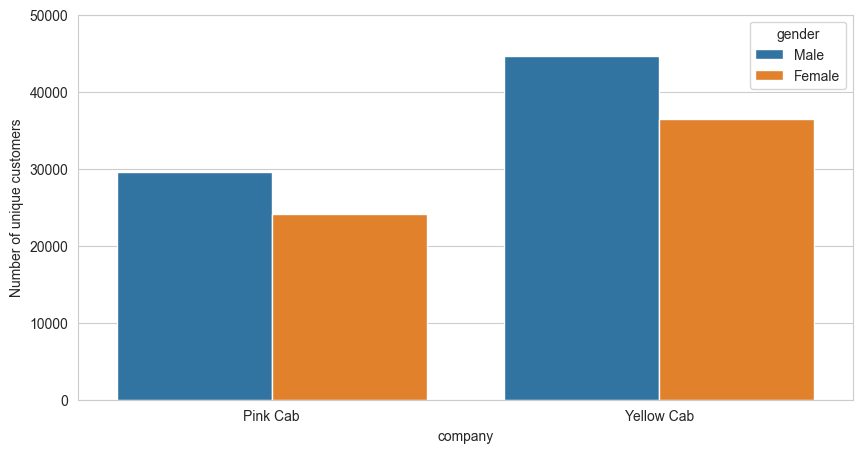

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.countplot(data=df_customers_agg, x='company', hue='gender', ax=ax)
ax.set_ybound(lower=0, upper=5e4)
ax.set_ylabel('Number of unique customers')
ax.set_xticklabels(['Pink Cab', 'Yellow Cab'])
#ax.legend('upper left');

Let's check if mean amount per trip is different among genders and companies

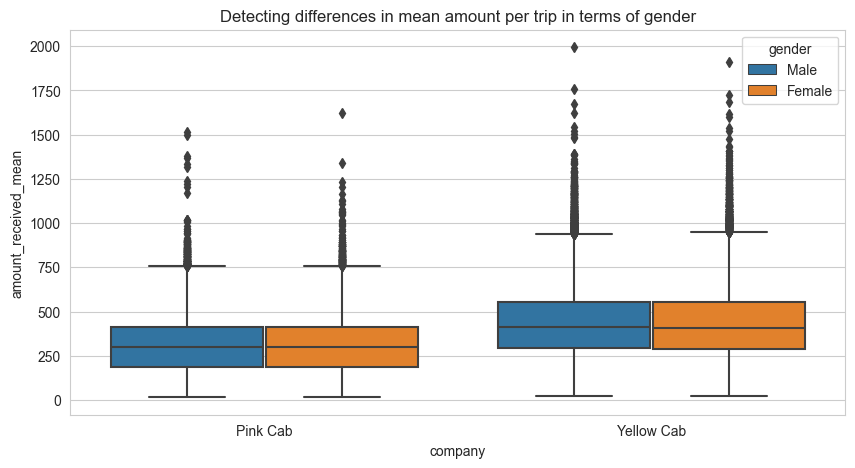

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.boxplot(data=df_customers_agg, x='company', y='amount_received_mean', hue='gender', ax=ax)
ax.set_xticklabels(['Pink Cab', 'Yellow Cab'])
ax.set_title('Detecting differences in mean amount per trip in terms of gender');

Here we see there's no significant difference between amounts paid by males and females

> Conclusion: even though male/female passengers number is different it has no influence on overall financial indicators as there's no difference between mean amounts paid by males and females

### 2.3. Customers' income segmentation

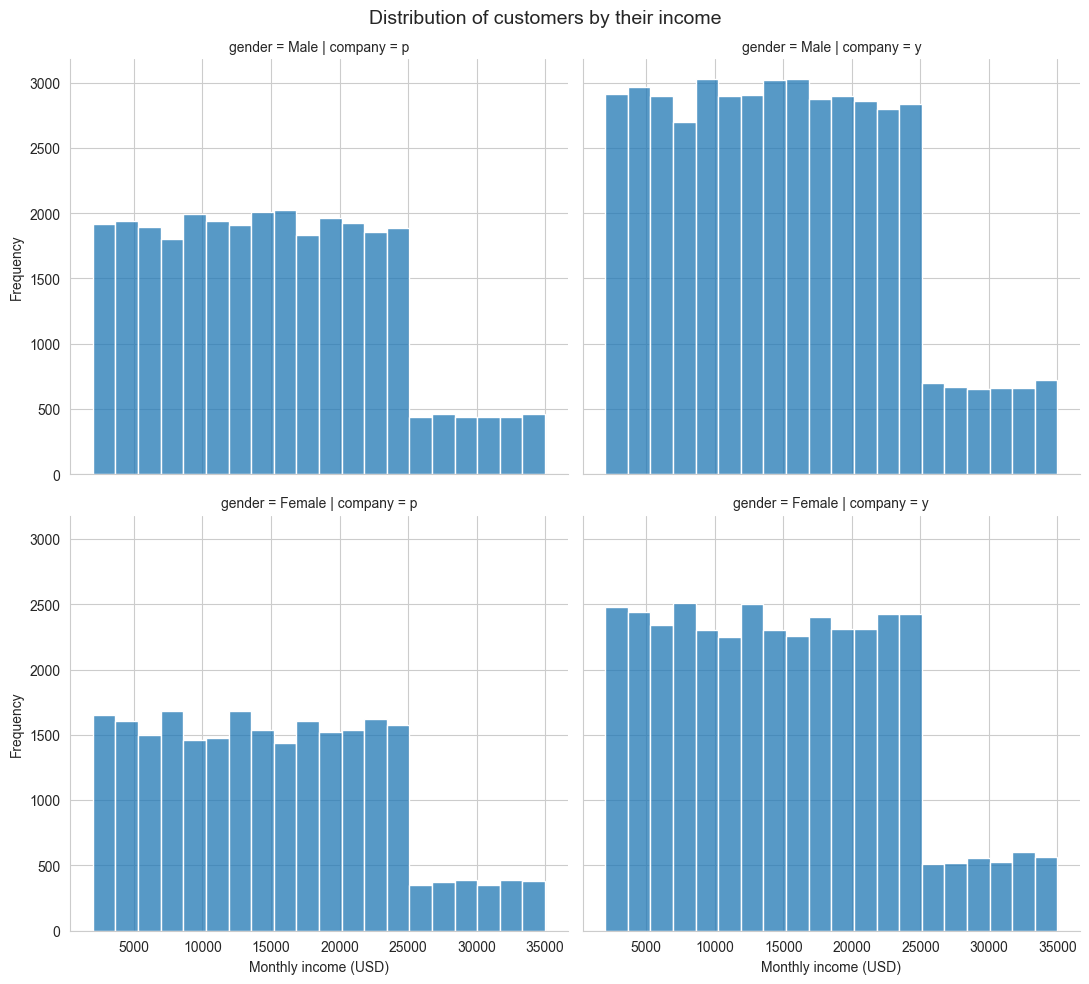

In [50]:
g = sns.FacetGrid(data=df_customers_agg, col='company', row='gender', height=5, aspect=1.1)
g.map(sns.histplot, 'monthly_income', bins=20)
g.figure.suptitle('Distribution of customers by their income', size=14)
g.figure.subplots_adjust(top=.93)
for ax in g.axes.flat:
    ax.set_xlabel('Monthly income (USD)')
    ax.set_ylabel('Frequency')

Here we can see there is no difference in distributions of passengers' income in terms of company and gender. All differences in frequency can be explained by differences in total passengers number

> Conclusion: we can't make segmentation of customers based on their gender and income

### 2.4. Customers' age segmentation

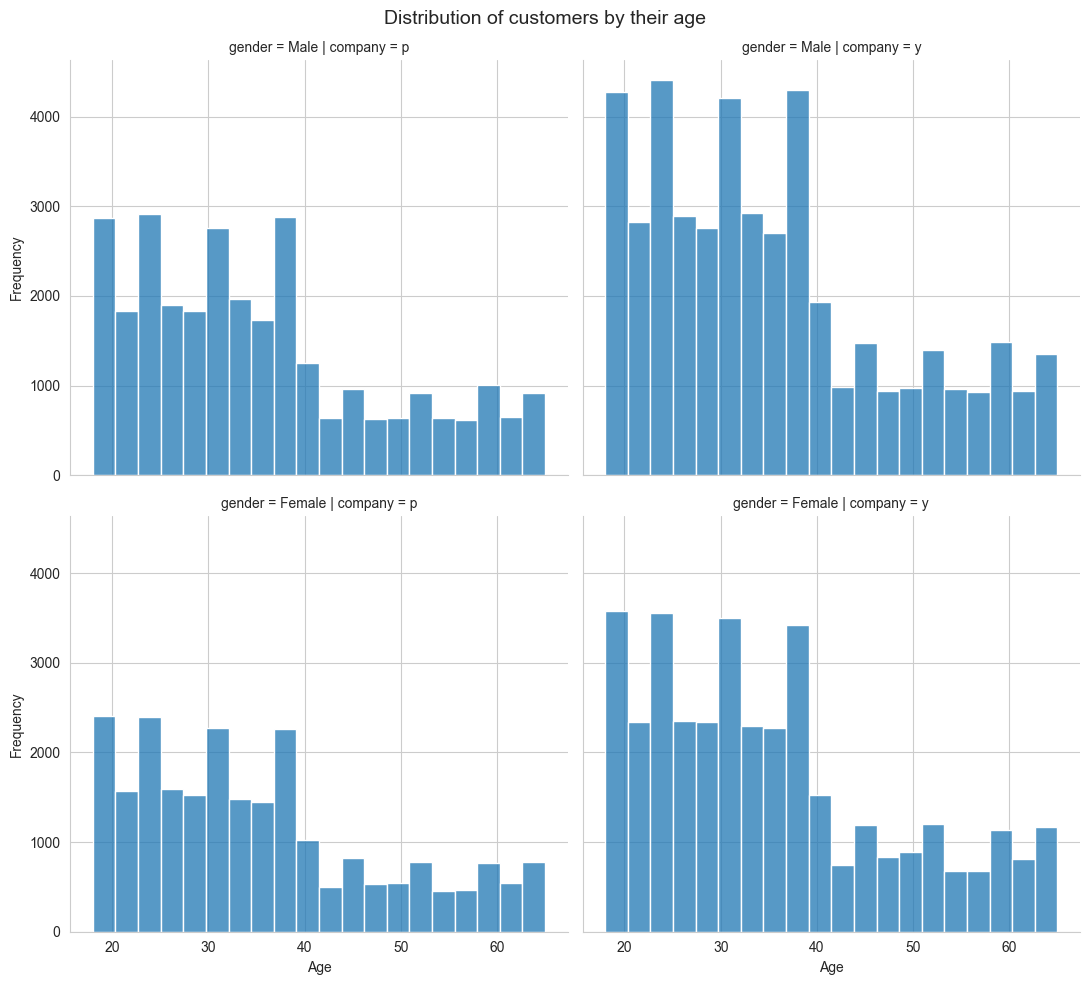

In [51]:
g = sns.FacetGrid(data=df_customers_agg, col='company', row='gender', height=5, aspect=1.1)
g.map(sns.histplot, 'age', bins=20)
g.figure.suptitle('Distribution of customers by their age', size=14)
g.figure.subplots_adjust(top=.93)
for ax in g.axes.flat:
    ax.set_xlabel('Age')
    ax.set_ylabel('Frequency')

<AxesSubplot: xlabel='age', ylabel='Density'>

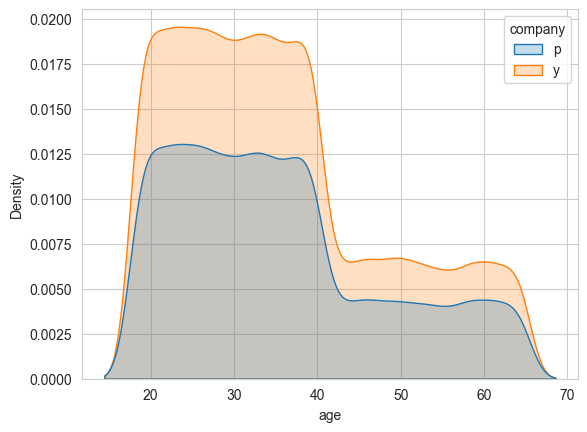

In [52]:
# Experimenting with kde representation
sns.kdeplot(data=df_customers_agg, x='age', hue='company', shade=True, common_grid=True) #cumulative=True, common_norm=False,

We see equal distribution of values in both samples. But this distribution is not normal => we can additionally use qqplot to confirm identical distributions

In [53]:
y_quantiles = []
p_quantiles = []
for i in range(101):
    y_quantiles.append(df_customers_agg[df_customers_agg['company'] == 'y']['age'].quantile(q=float(i)/100.0))
    p_quantiles.append(df_customers_agg[df_customers_agg['company'] == 'p']['age'].quantile(q=float(i)/100.0))

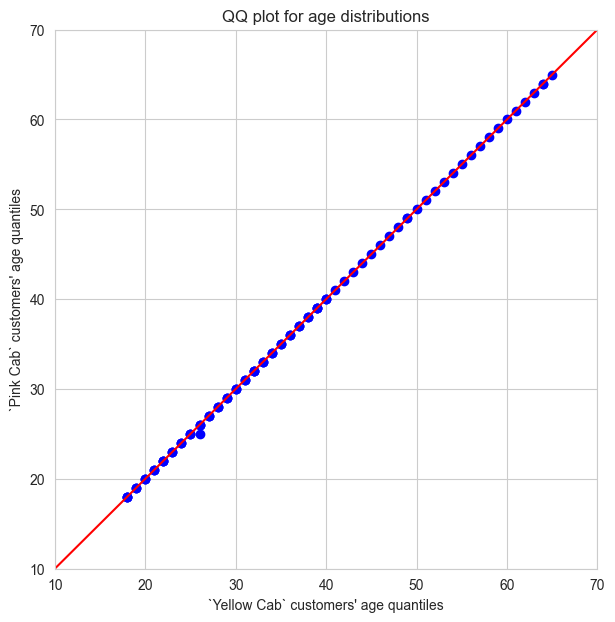

In [54]:
min_value = (min(p_quantiles[0], y_quantiles[0]) // 10 - 1) * 10
max_value = (max(p_quantiles[-1], y_quantiles[-1]) // 10 + 1) * 10
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.scatter(x=y_quantiles, y=p_quantiles, c='blue')
ax.plot([min_value, 70], [min_value, 70], c='red')
ax.set_xbound(lower=10, upper=70)
ax.set_ybound(lower=10, upper=70)
ax.set_xlabel("`Yellow Cab` customers' age quantiles")
ax.set_ylabel("`Pink Cab` customers' age quantiles")
ax.set_title('QQ plot for age distributions');
#ax.set_xticks([i for i in range(0, 71, 10)]);

Both companies' age ranges are fully overlap thus making segmentation impossible

### 2.5. Check correlation between customers' features 

We have to check if there's any dependencies between age, monthly income and mean amount received by companies per trip

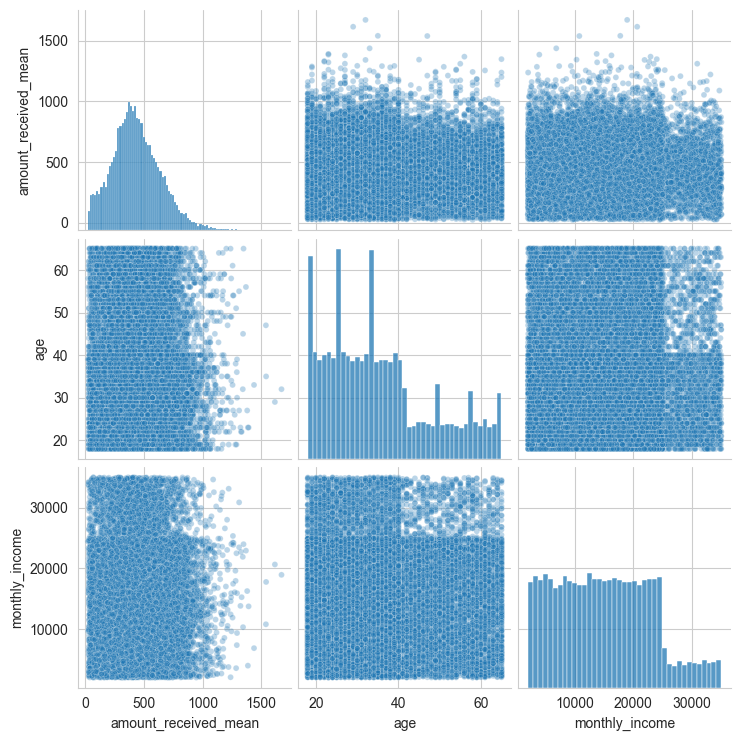

In [55]:
sns.pairplot(data=df_customers_agg[(df_customers_agg['company'] == 'y') & (df_customers_agg['trip_date'] == 2016)][['amount_received_mean', 'age', 'monthly_income']], plot_kws={'size': 2, 'alpha': 0.3})

There's no visible correlation between age and monthly income features and amount received per trip. Let's check it by Pearson's r and Spearman's roh

In [56]:
print("Pearson's correlation between age and monthly income:", stats.pearsonr(df_customers_agg['age'], df_customers_agg['monthly_income']))
print("Pearson's correlation between age and mean amount per trip:", stats.pearsonr(df_customers_agg['age'], df_customers_agg['amount_received_mean']))
print("Pearson's correlation between monthly income and mean amount per trip:", stats.pearsonr(df_customers_agg['amount_received_mean'], df_customers_agg['monthly_income']))

Pearson's correlation between age and monthly income: PearsonRResult(statistic=0.004564196218127519, pvalue=0.09366676976793709)
Pearson's correlation between age and mean amount per trip: PearsonRResult(statistic=-0.003085538858862157, pvalue=0.25710021528067234)
Pearson's correlation between monthly income and mean amount per trip: PearsonRResult(statistic=-0.00029503858024263017, pvalue=0.9137077994847309)


In [57]:
print("Spearman's correlation between age and monthly income:", stats.spearmanr(df_customers_agg['age'], df_customers_agg['monthly_income']))
print("Spearman's correlation between age and mean amount per trip:", stats.spearmanr(df_customers_agg['age'], df_customers_agg['amount_received_mean']))
print("Spearman's correlation between monthly income and mean amount per trip:", stats.spearmanr(df_customers_agg['amount_received_mean'], df_customers_agg['monthly_income']))

Spearman's correlation between age and monthly income: SpearmanrResult(correlation=0.005191094874747435, pvalue=0.056569984901377095)
Spearman's correlation between age and mean amount per trip: SpearmanrResult(correlation=-0.0034236901081580277, pvalue=0.20858345517047644)
Spearman's correlation between monthly income and mean amount per trip: SpearmanrResult(correlation=0.0002593779515157656, pvalue=0.9241040560359799)


All coefficients are small with respective p-values greater than significance level (0.05) thus displaying no linear or other correlation between values

### 2.6. Differences in payment type

Question: is there a difference in mean amount companies received by card and by cash?

In [58]:
df_payment_agg = df.groupby(by=['company', 'payment_type']).agg({
    'transaction_id': ['count'],
    'amount_received': ['mean', 'std']
}).reset_index()
df_payment_agg

company payment_type transaction_id amount_received          
                                count            mean       std
0       p         Card          50719        311.1973  182.0323
1       p         Cash          33992        310.2093  181.9420
2       y         Card         164785        457.9250  287.7055
3       y         Cash         109896        458.5674  289.4047

[Text(0, 0, 'Pink Cab'), Text(1, 0, 'Yellow Cab')]

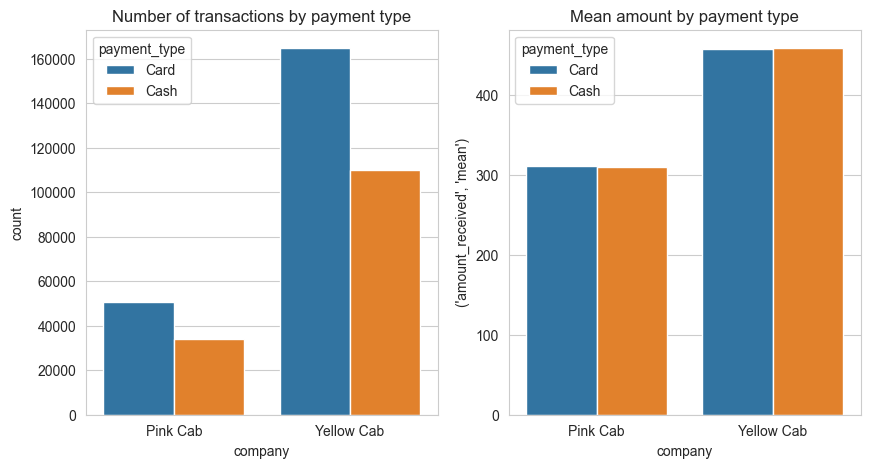

In [59]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
sns.countplot(data=df, x='company', hue='payment_type', ax=axs[0])
axs[0].set_title('Number of transactions by payment type')
axs[0].set_xticklabels(['Pink Cab', 'Yellow Cab'])
sns.barplot(data=df_payment_agg, x='company', y=('amount_received', 'mean'), hue='payment_type', ax=axs[1])
axs[1].set_title('Mean amount by payment type')
axs[1].set_xticklabels(['Pink Cab', 'Yellow Cab'])

> Conclusion: Mean transaction amounts are near equal. Thus there is no strong dependency beween payment type and financial results of companies

## Overall conclusions:

(1) Both companies have similar annual dynamics patterns in number of trips, trips total distance and amount received  
(2) 'Yellow Cab' company is about 3 times bigger than 'Pink Cab' in terms of total number of trips, trips distance and revenue based on known trips  
(3) 'Yellow Cab' has total amount of profit about 7-8 times bigger than 'Pink Cab' company  
(4) Mean trip distance for both companies are near equal (22.5-22.6 km)  
(5) Mean value of the amount received per trip for 'Yellow Cab' is higher by 140-150 USD while mean cost per trip is higher only by 49-50 USD. This tells us about perhaps more qualified marketing department in 'Yellow Cab' as the margin is twice as high as in 'Pink Cab'  
(6) Both companies have unprofitable trips. Total sum of losses by years looks similar. The difference is in quantity of such trips relative to total trips quantity: 'Pink Cab' have every 7th trip unprofitable while 'Yellow Cab' only each 20th.  
(7) Both companies have similar seasoning factor in their business according to data available. 'Pink Cab' company have 1.4 times greater seasonal variability compared to 'Yellow Cab' which can be more risky.  
(8) Based on statistical tests performed we can be sure that our values and conclusions about financial indicators of both companies in common are correct.  
(9) Difference betwen total number of customers didn't change significantly in 2016-2018. Using current trends 'Pink Cab's customers number will be equal to 'Yellow Cab's in 2100s. It's too far to take this opportunity into account when making investment decision.  
(10) There are 4 cities where 'Yellow Cab' significantly outperforms 'Pink Cab' in terms of revenue and number of trips while the difference in number of customers is not so big. These are Boston, Chicago, New York and Washington.  
(11) At least half of the differences between revenues and profits of the companies are explained by outstanding operational results of 'Yellow Cab' in New York. These results are stable in time (observed over 3 consecutive years).  
(12) Results of 'Yellow Cab' in New York are based on enormous trips quantity compared to 'Pink Cab' ones. It demands further investigation (compare results of both companies excluding New York, analyze situations in other 3 cities mentioned).  
(13) Differences between companies' mean values of the revenue per 1 km in different cities are statistically significant and they influence on financial results.  
(14) Analysis of customers' features (except geographical factors) didn't reveal any correlations. Thus there is impossible to classify customers in different segments.

## To DOs

(1) Explore further the situation with enormously high number of trips in NewYork, Boston, Chicago and Washington  
(2) Perform analysis of customers' location and if it possible to use it for segmentation